In [14]:
import os
import csv
import copy
import heapq
import struct
import inspect
import chardet
import itertools
import numpy as np
import collections
import pandas as pd
from typing import *
from time import time
import seaborn as sns
from sklearn.svm import SVC
from inspect import signature
from operator import itemgetter
from skimage.feature import hog
from numpy import random as rnd
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from sklearn.utils import shuffle
from lightgbm import LGBMClassifier
from scipy.stats import gaussian_kde
import matplotlib.font_manager as fm
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import make_scorer
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['axes.unicode_minus'] = False

# Scaling

In [2]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X[:])
def scale_robust(X_train, X_test):
    robustScaler = RobustScaler()
    robustScaler.fit(X_train[:])
    X_train = robustScaler.transform(X_train[:])
    X_test = robustScaler.transform(X_test[:])
#     print(f'Sample Scaled Data : {X_train[0]}')
    return [X_train[:], X_test[:]]


def scale_minmax(X_train, X_test):
    minmaxScaler = MinMaxScaler()
    minmaxScaler.fit(X_train[:])
    X_train = minmaxScaler.transform(X_train[:])
    X_test = minmaxScaler.transform(X_test[:])
#     print(f'Sample Scaled Data : {X_train[0]}')
    return [X_train[:], X_test[:]]

# Split Training, Test Set
(If required)

In [3]:
def split_set(X, y):
    # X_train, X_test, y_train, y_test
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression

In [4]:
class DiabetesModelingLR():
    def __init__(self):
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.clf = None
        self.training_size = None
        self.testing_size = None
        self.SCALE = True

    def make_model(self, X=None, y=None, X_train=None, y_train=None,
                   X_test=None, y_test=None, CV=False, C=1e-3, penalty='l1', SCALE=True):
        self.SCLAE = SCALE
        if X is not None:
            self.X, self.y = X, y
            self.X_train, self.X_test, self.y_train, self.y_test = split_set(X, y)
        else:
            self.X_train, self.y_train = X_train, y_train
            self.X_test, self.y_test = X_test, y_test

        if self.X_train.shape[1] != self.X_test.shape[1]:
            raise Exception('Training Set과 Test Set의 Feature가 다릅니다.')
        if self.SCALE:
            self.X_train, self.X_test = scale_robust(self.X_train, self.X_test)

        self.training_size = len(self.X_train)
        self.testing_size = len(self.X_test)
        if CV:
            self.clf = LogisticRegressionCV(
                cv=CV, solver='saga', penalty=penalty, n_jobs=-1, max_iter=5000)
#             self.clf = LogisticRegressionCV(cv=CV, solver='saga', penalty='l2')
        else:
            # solver = 'liblinear', 'newton-cg', 'lbfgs(l2)', 'sag', 'saga'
            self.clf = LogisticRegression(
                C=C, solver='liblinear', penalty=penalty, n_jobs=-1)

        self.clf.fit(self.X_train, self.y_train)

    def get_result(self):
        clf = self.clf
        f1score = round(f1_score(self.y_test, clf.predict(self.X_test)), 5)
#         accuracy = round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)
        y_predict = clf.predict(self.X_test)
        clf_report = classification_report(
            self.y_test, y_predict, target_names=['건강', '당뇨'])
        cm = confusion_matrix(self.y_test, y_predict)
        return [f1score, clf_report, cm]

    def get_f1_score(self):
        clf = self.clf
        f1score = f1_score(self.y_test, clf.predict(self.X_test))
        return f1score

    def show_result(self):
        clf = self.clf
        print(
            f'Training size : {self.training_size:,} Testing Size : {self.testing_size:,}')
        counts = np.unique(self.y_test, return_counts=True)[1]
        print(
            f'Test Set 당뇨병 인원수 : {counts[1]:,}명, 비당뇨병 인원수 : {counts[0]:,}명\n')
        print(f'Accuracy score: {round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)}', ' '*5,
              f'F1 Score: {round(f1_score(self.y_test, clf.predict(self.X_test)), 5)}\n')

        y_predict = clf.predict(self.X_test)
        print(classification_report(self.y_test,
                                    y_predict, target_names=['건강', '당뇨']))
        cm = confusion_matrix(self.y_test, y_predict)
        print('Confusion Matrix\n', cm)

# Support Vector Machine

In [5]:
class DiabetesModelingSVM():
    def __init__(self):
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.clf = None
        self.training_size = None
        self.testing_size = None
        self.SCALE = True

    def make_model(self, X=None, y=None, X_train=None, y_train=None, X_test=None, y_test=None,
                  SCALE=True):
        
        self.SCLAE = SCALE
        if X is not None:
            self.X, self.y = X, y
            self.X_train, self.X_test, self.y_train, self.y_test = split_set(X, y)
        else:
            self.X_train, self.y_train = X_train, y_train
            self.X_test, self.y_test = X_test, y_test

        if self.X_train.shape[1] != self.X_test.shape[1]:
            raise Exception('Training Set과 Test Set의 Feature가 다릅니다.')
        if self.SCALE:
            self.X_train, self.X_test = scale_robust(self.X_train, self.X_test)

        self.training_size = len(self.X_train)
        self.testing_size = len(self.X_test)
        self.clf = SVC(random_state=42, kernel='rbf',
                       gamma=0.1, C=1)
#         self.clf = SVC(C=1e-2, multi_class='ovr',
#                                  penalty='l2', solver='liblinear', tol=0.1)
#         if self.CROSSVAL:
#             self.clf = LogisticRegressionCV(C=1, multi_class='ovr', cv=5,
#                                  penalty='l2', solver='saga', tol=0.1)

        self.clf.fit(self.X_train, self.y_train)
#         clear_output()

    def get_result(self):
        clf = self.clf
        f1score = round(f1_score(self.y_test, clf.predict(self.X_test)), 5)
#         accuracy = round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)
        y_predict = clf.predict(self.X_test)
        clf_report = classification_report(
            self.y_test, y_predict, target_names=['건강', '당뇨'])
        cm = confusion_matrix(self.y_test, y_predict)
        return [f1score, clf_report, cm]

    def get_f1_score(self):
        clf = self.clf
        f1score = f1_score(self.y_test, clf.predict(self.X_test))
        return f1score

    def show_result(self):
        clf = self.clf
        print(
            f'Training size : {self.training_size:,} Testing Size : {self.testing_size:,}')
        counts = np.unique(self.y_test, return_counts=True)[1]
        print(
            f'Test Set 당뇨병 인원수 : {counts[1]:,}명, 비당뇨병 인원수 : {counts[0]:,}명\n')
        print(f'Accuracy score: {round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)}', ' '*5,
              f'F1 Score: {round(f1_score(self.y_test, clf.predict(self.X_test)), 5)}\n')

        y_predict = clf.predict(self.X_test)
        print(classification_report(self.y_test,
                                    y_predict, target_names=['건강', '당뇨']))
        cm = confusion_matrix(self.y_test, y_predict)
        print('Confusion Matrix\n', cm)

# Data Reading

In [6]:
class ReadData():
    def __init__(self, year=2017):
        self.year = year
        self.infos = []  # all infos from input
        self.data_infos = []  # features from read() object
        self.selected_features = None # selected features by user. set from self.get_features_index
        self.no_data = []  # datas with empty value
        self.required_info_index = []  # selected features' index
        self.no_data_count = collections.defaultdict(int)  # to count and show size of empty value
        self.X = []
        self.X_scaled = []
        self.y = []
        self.balanced_X = []
        self.balanced_y = []
        self.keep_FBS = False
        self.FBS_PIVOT = 120
        self.FBS_SCALED = 0
        self.input_params=[]
        self.FBS_MARGIN=0
        self.mean = 0
        self.normal_mean = 0
        self.diabetic_mean = 0
        self.normal_mean_list = []
        self.diabetic_mean_list = []

    def show_params(self):
        # shows parameters from read()
        sig = signature(self.read)
        params = []
        for param in sig.parameters.values():
            params.append(str(param.name)+'='+str(param.default))
        print(*params)

    def read(self, selected_features, DATASIZE=None, FBS_PIVOT=120, calculate_BMI=True, return_data=True,
             count_empty_data=False, filter_dict=None, keep_FBS=False, balance_size=False, FBS_MARGIN=1):
        
        
        # selected_features = features to select from data, DATASIZE = set limit(size) of data
        # FBS_PIVOT = if 식전혈당(공복혈당) >= FBS_PIVOT then set diabetic
        # if calculate_BMI is True = append BMI and remove height, weight
        # return_data = whether return X,y or not, count_empty_data = counts data with empty value
        # filter_dict = filtering outliers with this dict
        # keep_FBS = keep FBS at X (Caution)
        
        self.input_params = inspect.getargvalues(inspect.currentframe())[3]
        del self.input_params['self']
        self.FBS_MARGIN=FBS_MARGIN
        print(f'Reading Year {self.year}')
        if not DATASIZE:
            DATASIZE = float('inf')
        if self.year == 2017:
            FILENAME = 'NHIS_OPEN_GJ_2017_100.csv'
        elif self.year == 2018:
            FILENAME = 'NHIS_OPEN_GJ_2018_100.csv'
        else:
            raise Exception('year should be 2017 or 2018. default=2017')

        with open(FILENAME, 'rb') as f:
            ENCODING = chardet.detect(f.readline())['encoding']

        f = open(FILENAME, 'r', encoding=ENCODING)
        rdr = csv.reader(f)

        required_info_index = []

        for n, col in enumerate(rdr):  # read and store data from csv
            try:
                required_data = [info for index, info in enumerate(
                    col) if index in required_info_index]
            except:
                pass
            if n == 0:
                self.infos = col
                self.FBS_PIVOT = FBS_PIVOT
                self.get_features_index(selected_features)
                required_info_index = self.required_info_index
                self.data_infos = [info for index, info in enumerate(
                    col) if index in required_info_index]
                FBS_INDEX = self.infos.index('식전혈당(공복혈당)')
                if calculate_BMI:
                    if '신장(5Cm단위)' not in self.data_infos or '체중(5Kg단위)' not in self.data_infos:
                        calculate_BMI = False
                    else:
                        HEIGHT_INDEX, WEIGHT_INDEX = self.data_infos.index(
                            '신장(5Cm단위)'), self.data_infos.index('체중(5Kg단위)')
                        if WEIGHT_INDEX < HEIGHT_INDEX:
                            raise Exception(
                                'selected_features에서 신장을 체중보다 먼저 오도록 설정해주세요.')
            else:
                FBS = col[FBS_INDEX]
                if '' in required_data or FBS == '':
                    if count_empty_data:
                        l = [self.data_infos[i]
                             for i, d in enumerate(required_data) if d == '']
                        for s in l:
                            self.no_data_count[s] += 1
                        self.no_data.append(n)
                else:
                    self.X.append(required_data)
                    
                    if int(FBS) >= FBS_PIVOT:
                        self.y.append(1)
                    elif int(FBS) <= FBS_PIVOT - FBS_MARGIN:
                        self.y.append(0)
                    else:
                        self.X.pop()

            if n >= DATASIZE:
                break

        f.close()

        self.keep_FBS = keep_FBS
        if filter_dict:
            self.filter_outliers(filter_dict)
        if calculate_BMI:
            self.calculate_BMI()
        if self.keep_FBS == False:
            self.remove_FBS()

        self.X = np.array(self.X, dtype=np.float64)
        self.y = np.array(self.y)

        print(f"Reading Year {self.year}'s data done")
        print(f'Size of X = {len(self.X):,}, y = {len(self.y):,}')
        print(f'당뇨병 판별 공복혈당 기준 수치 : <={FBS_PIVOT - FBS_MARGIN} or >={FBS_PIVOT}')
        counts = np.unique(self.y, return_counts=True)[1]
        print(f'당뇨병 판별 환자 수 : {counts[1]:,}명, 비당뇨병 판별수 : {counts[0]:,}명\n')

        if balance_size:
            self.balance_size()

        print(f'X has {self.X.shape[1]} features')
        if count_empty_data:
            print(f'Size of data with empty value = {len(self.no_data):,}')
        print(f'Selected Features and Sample Data: \n{self.data_infos}')
        self.mean = list(map(lambda x:round(x, 2), np.mean(self.X, axis=0)))
        print(f'Mean : {self.mean}')
        print(f'{self.X[0]} , ', end='')
        print('당뇨') if self.y[0] == 1 else print('정상')
        print(f'{self.X[1]} , ', end='')
        print('당뇨') if self.y[1] == 1 else print('정상')
        if return_data:
            return [self.X, self.y]

    def calculate_BMI(self):
        # calculate and append BMI with height, weight and remove height, weight from data.
        try:
            HEIGHT_INDEX, WEIGHT_INDEX = self.data_infos.index(
                '신장(5Cm단위)'), self.data_infos.index('체중(5Kg단위)')
        except:
            raise Exception('신장 혹은 체중이 데이터에 없어서 BMI를 계산할 수 없습니다.')
        if WEIGHT_INDEX < HEIGHT_INDEX:
            raise Exception('selected_features 순서에서 신장을 체중보다 먼저 오도록 설정해주세요.')

        self.data_infos.append('BMI')
        del self.data_infos[HEIGHT_INDEX]
        del self.data_infos[WEIGHT_INDEX-1]
        
        if type(self.X) != list:
            self.X = [x.tolist() for x in self.X]

        for i in range(len(self.X)):
            height, weight = int(self.X[i].pop(HEIGHT_INDEX)), int(
                self.X[i].pop(WEIGHT_INDEX-1))
            BMI = round(weight / (height * height / 10000), 2)
            self.X[i].append(BMI)
            
        self.X = np.array(self.X, dtype=np.float64)
    
    def get_features_index(self, selected_features):
        # set selected features at object.
        for feature in selected_features:
            if feature not in self.infos:
                raise Exception(f"'{feature}'는 데이터에 없습니다.")
            self.required_info_index.append(self.infos.index(feature))
        self.required_info_index.sort()
        self.selected_features = selected_features
        
    def remove_FBS(self):
        if '식전혈당(공복혈당)' in self.data_infos and self.keep_FBS == False:
            FBS_index = self.data_infos.index('식전혈당(공복혈당)')
            del self.data_infos[FBS_index]
            if type(self.X) != list:
                self.X = [x.tolist() for x in self.X]
            for i in range(len(self.X)):
                del self.X[i][FBS_index]
        else:
            return
        self.X = np.array(self.X, dtype=np.float64)
                
    def show_outliers(self, feature: str, pivot: int, not_diabetes_only=True,
                     show_all=False, MAX_LEN=20):
        # shows outlier's value from specific feature and pivot.
        # if not_diabetes_only is True = shows outliers who is not diabetic.
        # if not_diabetes_only is False = shows all outliers.
        # if show_all is True = show all data of each outliers.
        OUT_INDEX = self.data_infos.index(feature)
        outliers = []
        if not_diabetes_only:
            fbs_index = self.data_infos.index('식전혈당(공복혈당)')
            bmi_index = self.data_infos.index('BMI')
            for i in range(len(self.X)):
                if self.y[i] != 1 and (self.X[i][OUT_INDEX] >= pivot or self.X[i][OUT_INDEX] <= 0):
                    outliers.append(i)
        else:
            for i in range(len(self.X)):
                if self.X[i][OUT_INDEX] >= pivot or self.X[i][OUT_INDEX] <= 0:
                    outliers.append(i)
        
        if not show_all:
            try:
                max_outlier = max([self.X[i][OUT_INDEX] for i in outliers])
            except:
                print(f'{feature}에서 {pivot} 이상의 데이터는 없습니다.')
        if not_diabetes_only:
            print(f'{feature}에서 기준치 {pivot} 이상이며, 당뇨가 아닌 사람들의 값입니다. ' +
                  f'(총 {len(outliers)}명, 비율: %.2f%%, 최댓값: {max_outlier})\n' % (len(outliers) * 100 / len(self.X)))

            print('{:>6} {:>16} {:>20} {:>10}'.format(
                'INDEX', feature, '식전혈당(공복혈당)', 'BMI'))
            for i in outliers if len(outliers) <= MAX_LEN else outliers[:MAX_LEN]:
                print('{:6} {:>22.0f} {:>28.0f} {:>10}'.format(i, self.X[i][OUT_INDEX],
                                                               self.X[i][fbs_index], self.X[i][bmi_index]))
        elif show_all:
            all_data = sorted([self.X[out].tolist() for out in outliers], key=itemgetter(OUT_INDEX), reverse=True)
            all_data = [[all_data[i].pop(OUT_INDEX)] + all_data[i] for i in range(len(all_data))]
            
            print(f'Feature : {feature}, Max Pivot : {pivot}, Size : {len(all_data)} ({round((len(all_data)*100)/len(self.X),2)}%)')
            print(*[self.data_infos[OUT_INDEX]] + self.data_infos[:OUT_INDEX] + self.data_infos[OUT_INDEX+1:])

            for data in all_data if len(all_data) <= MAX_LEN else all_data[:MAX_LEN]:
                for val in data: 
                    print(f'{val:>12}', end='')
                print('')
            if len(outliers) > MAX_LEN:
                print('....\n')
                
        else:
            print(f'{feature}에서 {pivot}보다 큰 값들입니다.' +
                  f'(총 {len(outliers)}명, 비율: %.2f%%, 최댓값: {max_outlier})\n' % (len(outliers) * 100 / len(self.X)))
            for i in outliers if len(outliers) <= MAX_LEN else outliers[:MAX_LEN]:
                print(self.X[i][OUT_INDEX])
            if len(outliers) > MAX_LEN:
                print('....\n')

    def sizeof_outliers(self, filter_dict):
        # only shows size of outliers who will be filtered by filter_dict.
        size = len(self.X)
        X_isnumpy = isinstance(self.X, np.ndarray)
        if X_isnumpy:
            filter_X = self.X[:].tolist()
            filter_y = self.y[:].tolist()
        else:
            filter_X = self.X[:]
            filter_y = self.y[:]
        filter_index = [self.data_infos.index(
            key) for key in list(filter_dict.keys())]
        filter_pivot = list(filter_dict.values())
        for f in range(len(filter_index)):
            max_pivot, min_pivot = filter_pivot[f]
            f_index = filter_index[f]
            max_out, min_out = 0, 0
            for i in range(len(filter_X)):
                if float(filter_X[i][f_index]) >= max_pivot:
                    max_out += 1
                elif float(filter_X[i][f_index]) <= min_pivot:
                    min_out += 1

            print(f'Max Pivot:{max_pivot:>5}, Min Pivot:{min_pivot:>5}, ' +
                  f'Max Outs: {max_out:>5,}, Min Outs: {min_out:>5,}, ' +
                  f'{(max_out+min_out)*100/size:>3.2f}% at {self.data_infos[f_index]:<20}')

    def filter_outliers(self, filter_dict):
        # excute filtering outliers by filter_dict. filter_dict[feature] = [MAX PIVOT, MIN PIVOT]
        print('Filtering outliers')
        original_size = len(self.X)
        X_isnumpy = isinstance(self.X, np.ndarray)
        if X_isnumpy:
            filter_X = self.X[:].tolist()
            filter_y = self.y[:].tolist()
        else:
            filter_X = self.X[:]
            filter_y = self.y[:]

        filter_index = [self.data_infos.index(key) for key in list(filter_dict.keys())]
        filter_pivot = list(filter_dict.values())

        for f in range(len(filter_index)):
            max_pivot, min_pivot = filter_pivot[f]
            max_filtered, min_filtered = 0, 0
            correction = 0
            f_index = filter_index[f]
            for i in range(len(filter_X)):
                val = float(filter_X[i - correction][f_index])
                if val >= max_pivot:
                    del filter_X[i - correction]
                    del filter_y[i - correction]
                    correction += 1
                    max_filtered += 1
                elif val <= min_pivot:
                    del filter_X[i - correction]
                    del filter_y[i - correction]
                    correction += 1
                    min_filtered += 1
            print(f'Filtered {correction:>5,} by {self.data_infos[f_index]} with pivot {[max_pivot, min_pivot]},'+
                  f' Size : {[max_filtered, min_filtered]}')
        if '식전혈당(공복혈당)' in self.data_infos and self.keep_FBS == False:
            FBS_index = self.data_infos.index('식전혈당(공복혈당)')
            del self.data_infos[FBS_index]
            for i in range(len(filter_X)):
                del filter_X[i][FBS_index]
        if X_isnumpy:
            self.X = np.array(filter_X[:], dtype=np.float64)
            self.y = np.array(filter_y[:])
        else:
            self.X, self.y = filter_X[:], filter_y[:]
        print(f'Filtered {original_size - len(self.X):,}. '+
              f'({(original_size - len(self.X))*100/original_size:.2f}%)  '+
              f'Filterd X size : {len(self.X):,}. ')

    def get_specific_data(self, features):
        if type(features) == str:
            return np.array(self.X[0:, self.data_infos.index(features)])

        index = [self.data_infos.index(feature) for feature in features]

        return np.array(self.X[0:, index])

    def balance_size(self, cal_priority=True, size=False, divide_mean=True):
        i, non_diabetes = 0, 0
#         BMI_index = self.data_infos.index('BMI')
#         self.balanced_X = [self.X[i][:BMI_index].tolist()+self.X[i][BMI_index+1:].tolist()
#                            for i in range(len(self.X)) if self.y[i] == 1 and self.X[i][BMI_index] >= 22]

        # label y=1인 것들은 모두 넣음
        self.balanced_X = [self.X[i].tolist() for i in range(len(self.X)) if self.y[i] == 1]
        self.balanced_y = [1] * len(self.balanced_X)
#         for _ in range(len(self.balanced_X)): self.balanced_y.append(1)
        heap = []
        self.calculate_mean(non_diabetes_only=divide_mean)
        
        if not size:
            size = len(self.balanced_X)
        
        if cal_priority:
            for i in range(len(self.X)):
                if divide_mean:
                    if self.y[i] == 1:
                        self.diabetic_mean_list.append(np.mean(self.X[i] / self.diabetic_mean))
                    else:
                        mean = abs(np.mean(self.X[i] / self.normal_mean) - 1)  # closest sets from mean
#                         mean = np.mean(self.X[i] / self.normal_mean)
                        heapq.heappush(heap, (mean, i))
                else:
                    if self.y[i] == 1:
                        self.diabetic_mean_list.append(np.mean(self.X[i] / self.mean))
                    mean = abs(np.mean(self.X[i] / self.mean) - 1)  # closest sets from mean
#                     mean = np.mean(self.X[i] / self.mean)  # farthest sets from mean
                    heapq.heappush(heap, (mean, i))
        
            self.normal_mean_list = heap[:]
#             max_mean = min(abs(max(self.diabetic_mean_list) - 1), abs(min(self.diabetic_mean_list) - 1))
            while non_diabetes < size:
#             while True:
                m, i = heapq.heappop(heap)
#                 if m >= max_mean:
#                     break
                self.balanced_X.append(self.X[i])
                self.balanced_y.append(0)
                non_diabetes += 1
                
        else:
            while non_diabetes < size:
                if self.y[i] == 0:
                    self.balanced_X.append(self.X[i])
                    self.balanced_y.append(0)
                    non_diabetes += 1
                i += 1

        self.balanced_X = np.array(self.balanced_X, dtype=np.float64)
        self.balanced_y = np.array(self.balanced_y)
        counts = np.unique(self.balanced_y, return_counts=True)[1]
        print(f'After Balancing Size  \n당뇨병 판별 환자 수 : {counts[1]:,}명, ' +
              f'비당뇨병 판별수 : {counts[0]:,}명 ' +
              f'(총 {len(self.balanced_X):,}명 = {len(self.balanced_X) * 100 / len(self.X):.2f}%)\n')
        self.X, self.y = self.balanced_X, self.balanced_y

    def scale(self, scaler: str, features=None):

        if features == None:
            X = self.X[:]
        else:
            X = self.get_specific_data(features)

        train, test, _, _ = train_test_split(X, self.y, test_size=0.2,
                                             random_state=42)
        if scaler == 'Robust':
            sc = RobustScaler()
        elif scaler == 'MinMax':
            sc = MinMaxScaler()
        elif scaler == 'Standard':
            sc = StandardScaler()
        else:
            raise Exception(f'Unable to scale with {scaler}')

        sc_train = sc.fit_transform(train)
        sc_test = sc.transform(test)
        if len(features) == 2:
            self.FBS_SCALED = sc.transform(
                np.array([[self.FBS_PIVOT, 0], [self.FBS_PIVOT, 0]]))[0][0]

        self.X_scaled = np.concatenate((sc_train, sc_test))

    def show_plt(self, x, y, scaler: str = None, title: str = 'No Title'):

        FBS_PIVOT = self.FBS_PIVOT

        if scaler:
            self.scale(scaler, features=[x, y])
            plt_x, plt_y = self.X_scaled[:, 0], self.X_scaled[:, 1]
            FBS_PIVOT = self.FBS_SCALED
            if title == 'No Title':
                title = scaler
        else:
            plt_x, plt_y = self.X[:, self.data_infos.index(x)], self.X[:, self.data_infos.index(y)]

        plt.scatter(plt_x, plt_y, color='red', marker='.')

        if x == '식전혈당(공복혈당)':
            plt.axvline(x=FBS_PIVOT, color='g', linestyle='--', linewidth=2)

        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(title)
        plt.show()

    def show_3D_plt(self, x, y, z, scaler: str = None):

        if scaler:
            self.scale(scaler, [x, y, z])
            plt_x, plt_y, plt_z = self.X_scaled[0:,
                                                0], self.X_scaled[0:, 1], self.X_scaled[0:, 2]
        else:
            plt_x = self.get_specific_data(x)
            plt_y = self.get_specific_data(y)
            plt_z = self.get_specific_data(z)

        fig = plt.figure(figsize=(8, 6))
        ax = Axes3D(fig)

        ax.scatter(plt_x, plt_y, plt_z)
        ax.set_xlabel(x, fontsize=15)
        ax.set_ylabel(y, fontsize=15)
        ax.set_zlabel(z, fontsize=15)

        plt.show()

    def show_density_plt(self, x, y, scaler: str = None, title: str = 'No Title'):

        FBS_PIVOT = self.FBS_PIVOT
        if scaler:
            self.scale(scaler, features=[x, y])
            plt_x, plt_y = self.X_scaled[:, 0], self.X_scaled[:, 1]
            FBS_PIVOT = self.FBS_SCALED
            if title == 'No Title':
                title = scaler
        else:
            plt_x, plt_y = self.X[:, self.data_infos.index(
                x)], self.X[:, self.data_infos.index(y)]

        # gaussian kde 계산
        xy = np.vstack([plt_x, plt_y])
        plt_z = gaussian_kde(xy)(xy)
        idx = plt_z.argsort()
        plt_x, plt_y, plt_z = plt_x[idx], plt_y[idx], plt_z[idx]

        # 시각화
        plt.figure(figsize=(8, 5))
        plt.scatter(plt_x, plt_y, c=plt_z, s=50, cmap=plt.cm.jet)

        if x == '식전혈당(공복혈당)':
            plt.axvline(x=FBS_PIVOT, color='green',
                        linestyle='--', linewidth=2)

        plt.title(title)
        plt.colorbar()
        plt.show()
        
    def show_data_range(self):
        range_list = [i for i in range(0, len(test.X), len(test.X)//10)]
        
        for i in range(len(self.data_infos)):
            data = [sorted(self.X, key=itemgetter(i))[p][i] for p in range_list]
            print(self.data_infos[i])
            for j, val in enumerate(data):
                d = str(j*10)+'% = '+str(int(val))
                print(f'{d:<10}', end='  ')
            print('')
    
    def set_data_range(self, range_dict, keep_FBS=None):
        
        [s.replace('%', '').split('~') for s in list(range_dict.values())]
        if keep_FBS:
            self.keep_FBS = keep_FBS
        keys = list(range_dict.keys())
        values = [list(map(int, s.replace('%', '').split('~'))) for s in list(range_dict.values())]
        sets = set()
        try:
            FBS_INDEX = self.data_infos.index('식전혈당(공복혈당)')
        except:
            print("값의 % 범위를 설정하려면 '식전혈당(공복혈당)'이 필요합니다.")
        original_size = len(self.X)
        print(f'Filter by Range')
        
        for X in self.X: sets.add(tuple(X))
        
        for vals in zip(keys, values):
            key_name, min_per, max_per = vals[0], *vals[1]
            try:
                key_index = self.data_infos.index(key_name)
            except:
                print(f'{key_name} Not in data infos.')
                continue
            max_range, min_range = (len(self.X) * max_per) // 100, (len(self.X) * min_per) // 100
            
            sorted_X = sorted(self.X[:], key=itemgetter(FBS_INDEX), reverse=True)
            sorted_X = sorted(sorted_X[:], key=itemgetter(key_index))
            MIN_PIVOT, MAX_PIVOT = sorted_X[min_range][key_index], sorted_X[max_range][key_index]
            sorted_X = map(tuple, sorted_X[min_range:max_range])
            
#             sorted_X = map(tuple, (sorted(sorted(self.X[min_range:max_range], key=itemgetter(FBS_INDEX), 
#                                                  reverse=True), 
#                                           key=itemgetter(key_index))))
            filtered_size = len(sets)
            filtered_set = set()
        
            for X in sorted_X:
                filtered_set.add(X)
            sets = sets & filtered_set
            filtered_size -= len(sets)
            
            print(f'Filtered {filtered_size:>5,} with range {min_per:>3}%~{max_per:>3}%, ',
                  f'values are in {MIN_PIVOT:<5} ~ {MAX_PIVOT:>5}',
                  f'by {self.data_infos[key_index]}')
            set_size = len(sets)
        
        self.X = np.array(list(map(np.array, sets)), dtype=np.float64)
        self.y = []
        correction = 0
        for i in range(len(self.X)):
            if self.X[i][FBS_INDEX] >= self.FBS_PIVOT:
                self.y.append(1)
            elif self.X[i][FBS_INDEX] <= self.FBS_PIVOT - self.FBS_MARGIN:
                self.y.append(0)
            else:
                self.X.pop(i - correction)
                correction += 1
            
        self.y = np.array(self.y)
        if not self.keep_FBS:
            self.remove_FBS()
        
        if len(self.X) != len(self.y):
            raise Exception(f'X와 y의 size가 다릅니다. X={len(self.X)}, y={len(self.y)}')
            
        print(f'\nFiltered {original_size - len(self.X):,} by data range from {original_size:,}. '+
              f'({(original_size - len(self.X))*100/original_size:.2f}%)  '+
              f'Filterd X size : {len(self.X):,}. ')
        
        print(f'당뇨병 판별 공복혈당 기준 수치 : <={self.FBS_PIVOT - self.FBS_MARGIN} or >={self.FBS_PIVOT}')
        counts = np.unique(self.y, return_counts=True)[1]
        print(f'당뇨병 판별 환자 수 : {counts[1]:,}명, 비당뇨병 판별수 : {counts[0]:,}명\n')
        
        print(f'X has {self.X.shape[1]} features')
        print(f'Selected Features and Sample Data: \n{self.data_infos}')
        self.calculate_mean()
        print(f'Mean : {self.mean}')
        print(f'{self.X[0]} , ', end='')
        print('당뇨') if self.y[0] == 1 else print('정상')
        print(f'{self.X[1]} , ', end='')
        print('당뇨') if self.y[1] == 1 else print('정상')
        
    def calculate_mean(self, non_diabetes_only=False):
        if non_diabetes_only:
            normal_X = [self.X[i] for i in range(len(self.X)) if self.y[i] == 0]
            diabetic_X = [self.X[i] for i in range(len(self.X)) if self.y[i] == 1]
            self.normal_mean = list(map(lambda x:round(x, 2), np.mean(normal_X, axis=0)))
            self.diabetic_mean = list(map(lambda x:round(x, 2), np.mean(diabetic_X, axis=0)))
        else:
            self.mean = list(map(lambda x:round(x, 2), np.mean(self.X, axis=0)))

# Selection by Priority Queue
## Procedure
- Data filtered by range filter  
- Remove height, weight and substitue to BMI. (get rid of big difference between man and woman)
- Lable diabetic data  
- Get mean value from whole data  
- Set priority queue and push non-diabetic's data in the queue with same size of diabetics  
- Remove FBS

In [7]:
filter_range_dict = {  # 'feature': 'MIN%~MAX%' to filter outlier
    '총콜레스테롤': '5%~95%',
    '트리글리세라이드': '5%~95%',
    'LDL콜레스테롤': '5%~95%',
    'HDL콜레스테롤': '5%~95%',
    '감마지티피': '5%~95%',
    '혈색소': '5%~95%',
    '(혈청지오티)ALT': '5%~95%',
    '(혈청지오티)AST': '5%~95%',
    '신장(5Cm단위)': '5%~95%',
    '체중(5Kg단위)': '5%~95%',
    '식전혈당(공복혈당)': '5%~99%'
}
test = ReadData()
test.read(list(filter_range_dict.keys()), return_data=False, keep_FBS=True, calculate_BMI=False,
          FBS_PIVOT = 125, FBS_MARGIN=10)

Reading Year 2017
Reading Year 2017's data done
Size of X = 952,625, y = 952,625
당뇨병 판별 공복혈당 기준 수치 : <=115 or >=125
당뇨병 판별 환자 수 : 80,472명, 비당뇨병 판별수 : 872,153명

X has 11 features
Selected Features and Sample Data: 
['신장(5Cm단위)', '체중(5Kg단위)', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피']
Mean : [162.22, 63.1, 99.54, 195.47, 130.65, 57.08, 113.07, 14.21, 25.83, 25.48, 36.36]
[170.   75.   99.  193.   92.   48.  126.   17.1  21.   35.   40. ] , 정상
[180.   80.  106.  228.  121.   55.  148.   15.8  20.   36.   27. ] , 정상


In [8]:
test.set_data_range(filter_range_dict)

Filter by Range
Filtered 95,259 with range   5%~ 95%,  values are in 138.0 ~ 261.0 by 총콜레스테롤
Filtered 82,049 with range   5%~ 95%,  values are in 46.0  ~ 294.0 by 트리글리세라이드
Filtered 28,943 with range   5%~ 95%,  values are in 60.0  ~ 172.0 by LDL콜레스테롤
Filtered 61,152 with range   5%~ 95%,  values are in 36.0  ~  84.0 by HDL콜레스테롤
Filtered 61,049 with range   5%~ 95%,  values are in 10.0  ~ 103.0 by 감마지티피
Filtered 56,117 with range   5%~ 95%,  values are in 11.7  ~  16.6 by 혈색소
Filtered 41,526 with range   5%~ 95%,  values are in 10.0  ~  58.0 by (혈청지오티)ALT
Filtered 27,853 with range   5%~ 95%,  values are in 15.0  ~  45.0 by (혈청지오티)AST
Filtered 51,508 with range   5%~ 95%,  values are in 150.0 ~ 175.0 by 신장(5Cm단위)
Filtered 28,302 with range   5%~ 95%,  values are in 45.0  ~  85.0 by 체중(5Kg단위)
Filtered 20,458 with range   5%~ 99%,  values are in 78.0  ~ 206.0 by 식전혈당(공복혈당)

Filtered 554,247 by data range from 952,625. (58.18%)  Filterd X size : 398,378. 
당뇨병 판별 공복혈당 기준 수치 : <=115 or >=125

In [9]:
print('Before calculate_BMI()', test.data_infos)
test.calculate_BMI()
print('After calculate_BMI()', test.data_infos)

Before calculate_BMI() ['신장(5Cm단위)', '체중(5Kg단위)', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피']
After calculate_BMI() ['식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']


In [10]:
print(f'Before remove_FBS {test.data_infos}')
print(test.X[0])
test.keep_FBS=False
test.remove_FBS()
print(f'After remove_FBS {test.data_infos}')
print(test.X[0])

Before remove_FBS ['식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
[111.   226.    98.    73.   133.    16.5   30.    36.    21.    28.89]
After remove_FBS ['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
[226.    98.    73.   133.    16.5   30.    36.    21.    28.89]


In [11]:
test.balance_size()
# test.balance_size(cal_priority=False)

After Balancing Size  
당뇨병 판별 환자 수 : 24,703명, 비당뇨병 판별수 : 24,703명 (총 49,406명 = 12.40%)



In [12]:
print(*test.data_infos)

총콜레스테롤 트리글리세라이드 HDL콜레스테롤 LDL콜레스테롤 혈색소 (혈청지오티)AST (혈청지오티)ALT 감마지티피 BMI


# Light GBM

In [39]:
class DiabetesModelingLGBM():
    def __init__(self):
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.clf = None
        self.training_size = None
        self.testing_size = None
        self.SCALE = True

    def make_model(self, X=None, y=None, X_train=None, y_train=None,
                   X_test=None, y_test=None, CV=False, C=1e-3, penalty='l1', SCALE=True):
        self.SCLAE = SCALE
        if X is not None:
            self.X, self.y = X, y
            self.X_train, self.X_test, self.y_train, self.y_test = split_set(X, y)
        else:
            self.X_train, self.y_train = X_train, y_train
            self.X_test, self.y_test = X_test, y_test

        if self.X_train.shape[1] != self.X_test.shape[1]:
            raise Exception('Training Set과 Test Set의 Feature가 다릅니다.')
        if self.SCALE:
            self.X_train, self.X_test = scale_robust(self.X_train, self.X_test)

        self.training_size = len(self.X_train)
        self.testing_size = len(self.X_test)
        
        self.clf = LGBMClassifier(learning_rate=0.2, max_depth=6, min_samples_leaf=3,
                                  n_estimators=400, random_state=42)

        self.clf.fit(self.X_train, self.y_train)

    def get_result(self):
        clf = self.clf
        f1score = round(f1_score(self.y_test, clf.predict(self.X_test)), 5)
#         accuracy = round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)
        y_predict = clf.predict(self.X_test)
        clf_report = classification_report(
            self.y_test, y_predict, target_names=['건강', '당뇨'])
        cm = confusion_matrix(self.y_test, y_predict)
        return [f1score, clf_report, cm]

    def get_f1_score(self):
        clf = self.clf
        f1score = f1_score(self.y_test, clf.predict(self.X_test))
        return f1score

    def show_result(self):
        clf = self.clf
        print(
            f'Training size : {self.training_size:,} Testing Size : {self.testing_size:,}')
        counts = np.unique(self.y_test, return_counts=True)[1]
        print(
            f'Test Set 당뇨병 인원수 : {counts[1]:,}명, 비당뇨병 인원수 : {counts[0]:,}명\n')
        print(f'Accuracy score: {round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)}', ' '*5,
              f'F1 Score: {round(f1_score(self.y_test, clf.predict(self.X_test)), 5)}\n')

        y_predict = clf.predict(self.X_test)
        print(classification_report(self.y_test,
                                    y_predict, target_names=['건강', '당뇨']))
        cm = confusion_matrix(self.y_test, y_predict)
        print('Confusion Matrix\n', cm)

In [41]:
test_LR = DiabetesModelingLGBM()
test_LR.make_model(X=test.X, y=test.y)
# test_LR.make_model(X=test.X, y=test.y, CV=5)
# test_LR.make_model(X_train=test.X, y_train=test.y, X_test=test2018.X, y_test=test2018.y)
# clear_output()
print(*test.data_infos)
# print('',*test.data_infos,'\n', *test2018.data_infos)
test_LR.show_result()
# for d in sorted(zip(test.data_infos, *test_LR.clf.coef_), key=itemgetter(1), reverse=True):
#     print(d[0], ':', d[1])

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
총콜레스테롤 트리글리세라이드 HDL콜레스테롤 LDL콜레스테롤 혈색소 (혈청지오티)AST (혈청지오티)ALT 감마지티피 BMI
Training size : 39,524 Testing Size : 9,882
Test Set 당뇨병 인원수 : 4,941명, 비당뇨병 인원수 : 4,941명

Accuracy score: 0.88322       F1 Score: 0.87415

              precision    recall  f1-score   support

          건강       0.83      0.96      0.89      4941
          당뇨       0.95      0.81      0.87      4941

    accuracy                           0.88      9882
   macro avg       0.89      0.88      0.88      9882
weighted avg       0.89      0.88      0.88      9882

Confusion Matrix
 [[4720  221]
 [ 933 4008]]


In [19]:
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
X_train, X_test, y_train, y_test = split_set(test.X, test.y)

In [21]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print(f1_score(y_test, pred))
print(confusion_matrix(y_test, pred))

0.7562111801242236
[[4275  666]
 [1532 3409]]


In [22]:
gb_param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf': [3, 5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.2]
}

In [25]:
gb_grid = GridSearchCV(gb, param_grid=gb_param_grid, scoring='f1', n_jobs=-1, verbose=1)
gb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [3, 5, 7, 10],
                         'n_estimators': [100, 200, 400]},
             scoring='f1', verbose=1)

In [37]:
cv_result_df = pd.DataFrame(gb_grid.cv_results_)
cv_result_df.sort_values(by=['rank_test_score'], inplace=True)
cv_result_df[['params', 'mean_test_score', 'rank_test_score']].head(10)

params  mean_test_score  \
98   {'learning_rate': 0.2, 'max_depth': 6, 'min_sa...         0.868571   
104  {'learning_rate': 0.2, 'max_depth': 6, 'min_sa...         0.868336   
62   {'learning_rate': 0.1, 'max_depth': 8, 'min_sa...         0.868166   
65   {'learning_rate': 0.1, 'max_depth': 8, 'min_sa...         0.867966   
82   {'learning_rate': 0.1, 'max_depth': 10, 'min_s...         0.867932   
68   {'learning_rate': 0.1, 'max_depth': 8, 'min_sa...         0.867872   
35   {'learning_rate': 0.05, 'max_depth': 10, 'min_...         0.867824   
107  {'learning_rate': 0.2, 'max_depth': 6, 'min_sa...         0.867479   
101  {'learning_rate': 0.2, 'max_depth': 6, 'min_sa...         0.867395   
32   {'learning_rate': 0.05, 'max_depth': 10, 'min_...         0.867134   

     rank_test_score  
98                 1  
104                2  
62                 3  
65                 4  
82                 5  
68                 6  
35                 7  
107                8  
101                9  
32                10

In [38]:
gb_grid.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, max_depth=6, min_samples_leaf=3,
                           n_estimators=400, random_state=42)

In [24]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=200)
evals = [(X_test, y_test)]
lgbm.fit(X_train, y_train)
preds = lgbm.predict(X_test)

In [28]:
print(f1_score(y_test, preds))

0.8470483996012848


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

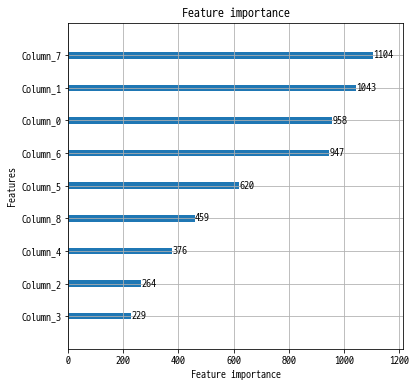

In [29]:
from lightgbm import plot_importance
%matplotlib inline

f, ax = plt.subplots(figsize=(6, 6))
plot_importance(lgbm, max_num_features=15, ax=ax)

In [30]:
test.data_infos

['총콜레스테롤',
 '트리글리세라이드',
 'HDL콜레스테롤',
 'LDL콜레스테롤',
 '혈색소',
 '(혈청지오티)AST',
 '(혈청지오티)ALT',
 '감마지티피',
 'BMI']

# XGBoost

In [35]:
import xgboost as xgb
from xgboost import plot_importance
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)
params = {'max_depth' : 3,
         'eta' : 0.1, 
         'objective' : 'binary:logistic',
         'eval_metric' : 'logloss',
         'early_stoppings' : 100 }
num_rounds = 400
xgb_model = xgb.train(dtrain=dtrain, params=params)


[04:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [36]:
wlist = [(dtrain, 'train'), (dtest,'eval')]
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[04:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.66964	eval-logloss:0.67002
[1]	train-logloss:0.65127	eval-logloss:0.65212
[2]	train-logloss:0.63518	eval-logloss:0.63612
[3]	train-logloss:0.61994	eval-logloss:0.62118
[4]	train-logloss:0.60880	eval-logloss:0.61014
[5]	train-logloss:0.59644	eval-logloss:0.59794
[6]	train-logloss:0.58836	eval-logloss:0.59002
[7]	train-logloss:0.58166	eval-logloss:0.58350
[8]	train-logloss:0.57308	eval-logloss:0.57481
[9]	train-logloss:0.56796	eval-logloss:0.57003
[10]	train-logloss:0.56320	eval-logloss:0.56530
[11]	train-logloss:0.55583	eval-logloss:0.55836
[12]	train-logloss:0.55225	eval-logloss

[162]	train-logloss:0.45098	eval-logloss:0.45904
[163]	train-logloss:0.45095	eval-logloss:0.45900
[164]	train-logloss:0.45075	eval-logloss:0.45887
[165]	train-logloss:0.45057	eval-logloss:0.45877
[166]	train-logloss:0.45041	eval-logloss:0.45866
[167]	train-logloss:0.45038	eval-logloss:0.45864
[168]	train-logloss:0.45033	eval-logloss:0.45861
[169]	train-logloss:0.45030	eval-logloss:0.45860
[170]	train-logloss:0.45028	eval-logloss:0.45858
[171]	train-logloss:0.45010	eval-logloss:0.45851
[172]	train-logloss:0.45008	eval-logloss:0.45850
[173]	train-logloss:0.44979	eval-logloss:0.45827
[174]	train-logloss:0.44928	eval-logloss:0.45782
[175]	train-logloss:0.44913	eval-logloss:0.45762
[176]	train-logloss:0.44810	eval-logloss:0.45678
[177]	train-logloss:0.44652	eval-logloss:0.45511
[178]	train-logloss:0.44635	eval-logloss:0.45503
[179]	train-logloss:0.44609	eval-logloss:0.45486
[180]	train-logloss:0.44576	eval-logloss:0.45455
[181]	train-logloss:0.44540	eval-logloss:0.45429
[182]	train-logloss:

[330]	train-logloss:0.40309	eval-logloss:0.41646
[331]	train-logloss:0.40276	eval-logloss:0.41618
[332]	train-logloss:0.40243	eval-logloss:0.41586
[333]	train-logloss:0.40216	eval-logloss:0.41570
[334]	train-logloss:0.40196	eval-logloss:0.41547
[335]	train-logloss:0.40126	eval-logloss:0.41493
[336]	train-logloss:0.40084	eval-logloss:0.41453
[337]	train-logloss:0.40068	eval-logloss:0.41443
[338]	train-logloss:0.40062	eval-logloss:0.41440
[339]	train-logloss:0.40046	eval-logloss:0.41426
[340]	train-logloss:0.40035	eval-logloss:0.41417
[341]	train-logloss:0.40025	eval-logloss:0.41408
[342]	train-logloss:0.40024	eval-logloss:0.41408
[343]	train-logloss:0.40021	eval-logloss:0.41409
[344]	train-logloss:0.40012	eval-logloss:0.41404
[345]	train-logloss:0.40010	eval-logloss:0.41402
[346]	train-logloss:0.40004	eval-logloss:0.41393
[347]	train-logloss:0.39989	eval-logloss:0.41389
[348]	train-logloss:0.39977	eval-logloss:0.41381
[349]	train-logloss:0.39846	eval-logloss:0.41243
[350]	train-logloss:

In [41]:
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10], 3))
pred = [ 1 if x > 0.5 else 0 for x in pred_probs]

[0.992 1.    0.344 0.169 0.48  0.217 0.371 0.671 0.319 0.469]


In [42]:
print(confusion_matrix(y_test, pred))
print(f1_score(y_test, pred))

[[4496  445]
 [1319 3622]]
0.8041740674955594


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

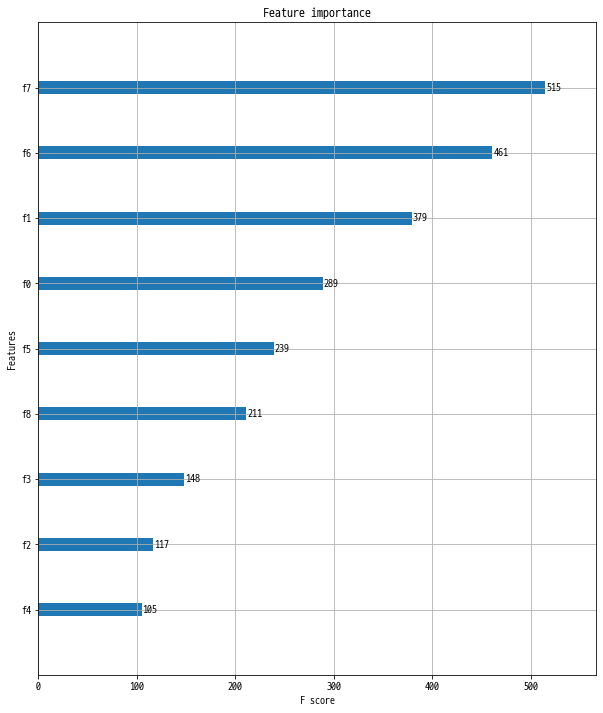

In [43]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

# ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

In [38]:
test_LR = DiabetesModelingLR()
test_LR.make_model(X=test.X, y=test.y, penalty='l2')
# test_LR.make_model(X=test.X, y=test.y, CV=5)
# test_LR.make_model(X_train=test.X, y_train=test.y, X_test=test2018.X, y_test=test2018.y)
# clear_output()
print(*test.data_infos)
# print('',*test.data_infos,'\n', *test2018.data_infos)
test_LR.show_result()
for d in sorted(zip(test.data_infos, *test_LR.clf.coef_), key=itemgetter(1), reverse=True):
    print(d[0], ':', d[1])

총콜레스테롤 트리글리세라이드 HDL콜레스테롤 LDL콜레스테롤 혈색소 (혈청지오티)AST (혈청지오티)ALT 감마지티피 BMI
Training size : 39,524 Testing Size : 9,882
Test Set 당뇨병 인원수 : 4,941명, 비당뇨병 인원수 : 4,941명

Accuracy score: 0.6699       F1 Score: 0.65692

              precision    recall  f1-score   support

          건강       0.66      0.71      0.68      4941
          당뇨       0.68      0.63      0.66      4941

    accuracy                           0.67      9882
   macro avg       0.67      0.67      0.67      9882
weighted avg       0.67      0.67      0.67      9882

Confusion Matrix
 [[3497 1444]
 [1818 3123]]
감마지티피 : 0.6319541895182197
(혈청지오티)ALT : 0.3924307267735737
트리글리세라이드 : 0.30635787444232
BMI : 0.22518611658121665
(혈청지오티)AST : 0.004499385313184189
혈색소 : -0.12931384377537064
HDL콜레스테롤 : -0.1512875434957277
총콜레스테롤 : -0.19976831103155754
LDL콜레스테롤 : -0.2720676013364638


c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


In [39]:
model2017SVM = DiabetesModelingSVM()
model2017SVM.make_model(X=test.X, y=test.y)
print(*test.data_infos)
test_LR.show_result()
for d in sorted(zip(test.data_infos, *test_LR.clf.coef_), key=itemgetter(1), reverse=True):
    print(d[0], ':', d[1])

총콜레스테롤 트리글리세라이드 HDL콜레스테롤 LDL콜레스테롤 혈색소 (혈청지오티)AST (혈청지오티)ALT 감마지티피 BMI
Training size : 39,524 Testing Size : 9,882
Test Set 당뇨병 인원수 : 4,941명, 비당뇨병 인원수 : 4,941명

Accuracy score: 0.6699       F1 Score: 0.65692

              precision    recall  f1-score   support

          건강       0.66      0.71      0.68      4941
          당뇨       0.68      0.63      0.66      4941

    accuracy                           0.67      9882
   macro avg       0.67      0.67      0.67      9882
weighted avg       0.67      0.67      0.67      9882

Confusion Matrix
 [[3497 1444]
 [1818 3123]]
감마지티피 : 0.6319541895182197
(혈청지오티)ALT : 0.3924307267735737
트리글리세라이드 : 0.30635787444232
BMI : 0.22518611658121665
(혈청지오티)AST : 0.004499385313184189
혈색소 : -0.12931384377537064
HDL콜레스테롤 : -0.1512875434957277
총콜레스테롤 : -0.19976831103155754
LDL콜레스테롤 : -0.2720676013364638


In [40]:
model2017SVM = DiabetesModelingSVM()
model2017SVM.make_model(X=test.X, y=test.y)
# 1h 22m
# 1m with data 50,000 (filter by range, balance with priority queue)
# 4sec with data 20,000 (filter by range, balance with priority queue)

In [41]:
model2017SVM.show_result()
# 52m

Training size : 39,524 Testing Size : 9,882
Test Set 당뇨병 인원수 : 4,941명, 비당뇨병 인원수 : 4,941명

Accuracy score: 0.88383       F1 Score: 0.86889

              precision    recall  f1-score   support

          건강       0.81      1.00      0.90      4941
          당뇨       1.00      0.77      0.87      4941

    accuracy                           0.88      9882
   macro avg       0.90      0.88      0.88      9882
weighted avg       0.90      0.88      0.88      9882

Confusion Matrix
 [[4930   11]
 [1137 3804]]


# ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

In [9]:
test2018 = ReadData(2018)
test2018.read(list(filter_range_dict.keys()), return_data=False, keep_FBS=True, calculate_BMI=False,
          FBS_PIVOT = 125, FBS_MARGIN=10)
test2018.set_data_range(filter_range_dict)
test2018.calculate_BMI()
test2018.keep_FBS=False
test2018.remove_FBS()
test2018.balance_size()
print(test2018.X.shape)
print(*test2018.data_infos)

Reading Year 2018
Reading Year 2018's data done
Size of X = 309,334, y = 309,334
당뇨병 판별 공복혈당 기준 수치 : <=115 or >=125
당뇨병 판별 환자 수 : 30,114명, 비당뇨병 판별수 : 279,220명

X has 11 features
Selected Features and Sample Data: 
['신장(5Cm단위)', '체중(5Kg단위)', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피']
Mean : [161.65, 63.25, 100.93, 195.29, 125.55, 56.84, 113.63, 14.26, 26.7, 26.27, 36.92]
[150.   45.  100.  234.   90.   80.  135.   12.7  19.   10.   13. ] , 정상
[175.   65.   80.  171.  168.   34.  103.   13.5 101.   26.  446. ] , 정상
Filter by Range
Filtered 30,930 with range   5%~ 95%,  values are in 135.0 ~ 261.0 by 총콜레스테롤
Filtered 27,224 with range   5%~ 95%,  values are in 48.0  ~ 268.0 by 트리글리세라이드
Filtered 8,781 with range   5%~ 95%,  values are in 59.0  ~ 173.0 by LDL콜레스테롤
Filtered 20,295 with range   5%~ 95%,  values are in 37.0  ~  84.0 by HDL콜레스테롤
Filtered 20,409 with range   5%~ 95%,  values are in 11.0  ~ 102.0 by 감마지티피
Filtered 18,107

In [102]:
print(*test.data_infos)
print(test.X[0:5])
print(test.y[0:5])
print(*test2018.data_infos)
print(test2018.X[0:5])
print(test2018.y[0:5])

총콜레스테롤 트리글리세라이드 HDL콜레스테롤 LDL콜레스테롤 혈색소 (혈청지오티)AST (혈청지오티)ALT 감마지티피 BMI
[[206.    96.    77.   110.    15.4   37.    57.    71.    28.89]
 [225.   129.    51.   148.    15.4   19.    23.    41.    31.22]
 [164.    97.    55.    89.    16.4   28.    32.    62.    27.68]
 [191.    64.    68.   110.    14.3   19.    16.    16.    20.2 ]
 [182.   104.    58.   103.    13.9   18.    16.    24.    28.89]]
[1 1 1 1 1]


NameError: name 'test2018' is not defined

In [77]:
print(list(zip(test.data_infos, *test_LR.clf.coef_)))

[('총콜레스테롤', 7.118813745566638), ('트리글리세라이드', 11.470540177081684), ('HDL콜레스테롤', 4.3736316217121285), ('LDL콜레스테롤', 2.8470233030080965), ('혈색소', 2.862731106965009), ('(혈청지오티)AST', 7.502909391558161), ('(혈청지오티)ALT', 12.557353509895144), ('감마지티피', 14.114265312363708), ('BMI', 5.144884192820912)]


In [81]:
test_LR = DiabetesModelingLR()
test_LR.make_model(X=test.get_specific_data(labels), y=test.y, CV=5)
# test_LR.make_model(X_train=test.X, y_train=test.y, X_test=test2018.X, y_test=test2018.y)
# clear_output()
print(*test.data_infos)
# print('',*test.data_infos,'\n', *test2018.data_infos)
test_LR.show_result()
for d in sorted(zip(labels, *test_LR.clf.coef_), key=itemgetter(1), reverse=True):
    print(d[0], ':', d[1])

총콜레스테롤 트리글리세라이드 HDL콜레스테롤 LDL콜레스테롤 혈색소 (혈청지오티)AST (혈청지오티)ALT 감마지티피 BMI
Training size : 18,443 Testing Size : 4,611
Test Set 당뇨병 인원수 : 2,305명, 비당뇨병 인원수 : 2,306명

Accuracy score: 0.99414       F1 Score: 0.99411

              precision    recall  f1-score   support

          건강       0.99      1.00      0.99      2306
          당뇨       1.00      0.99      0.99      2305

    accuracy                           0.99      4611
   macro avg       0.99      0.99      0.99      4611
weighted avg       0.99      0.99      0.99      4611

Confusion Matrix
 [[2306    0]
 [  27 2278]]
감마지티피 : 13.930835914637646
(혈청지오티)ALT : 12.368273583448673
트리글리세라이드 : 10.238589761033111
총콜레스테롤 : 10.194955162853903
(혈청지오티)AST : 7.396818529353436
BMI : 5.083577166028557
HDL콜레스테롤 : 3.008613277140604
혈색소 : 2.8035719853086234


#### Coefficient Function trained by data with balanced pick

In [137]:
for d in zip(test.data_infos, *test_LR.clf.coef_):
    print(d[0], ':', d[1])

총콜레스테롤 : 0.0005066548901149848
트리글리세라이드 : 1.3120991744065524
(혈청지오티)AST : 0.9254949833144597
(혈청지오티)ALT : 0.6372099740396046
감마지티피 : 0.898080542201869
BMI : 1.0003078477631433


In [22]:
test1 = ReadData()
test1.read(list(filter_range_dict.keys()), return_data=False, keep_FBS=True, calculate_BMI=True,
          FBS_PIVOT = 125, FBS_MARGIN=0)
clear_output()

In [10]:
test2 = ReadData()
test2.read(list(filter_range_dict.keys()), return_data=False, keep_FBS=True, calculate_BMI=True,
          FBS_PIVOT = 125, FBS_MARGIN=0)

Reading Year 2017
Reading Year 2017's data done
Size of X = 997,068, y = 997,068
당뇨병 판별 공복혈당 기준 수치 : <=125 or >=125
당뇨병 판별 환자 수 : 80,472명, 비당뇨병 판별수 : 916,596명

X has 10 features
Selected Features and Sample Data: 
['식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
Mean : [100.43, 195.51, 132.08, 56.94, 113.0, 14.22, 25.98, 25.73, 37.11, 23.91]
[ 99.   193.    92.    48.   126.    17.1   21.    35.    40.    25.95] , 정상
[106.   228.   121.    55.   148.    15.8   20.    36.    27.    24.69] , 정상


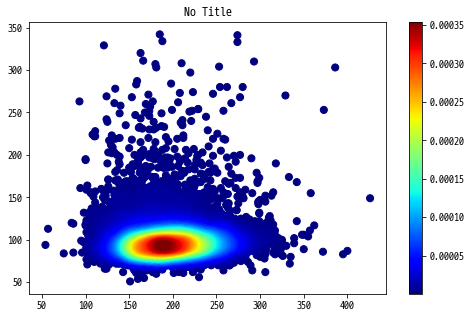

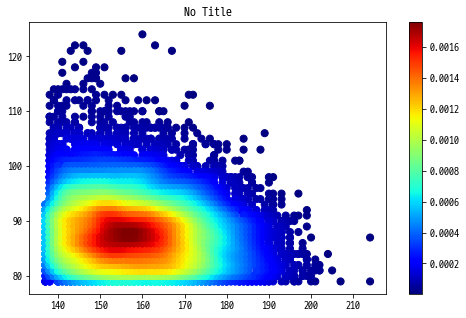

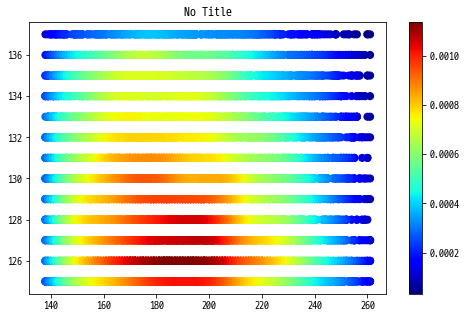

In [38]:
test2.X = np.array([test1.X[i] for i in range(len(test.X)) if test.y[i] == 0])
test2.show_density_plt('총콜레스테롤', '식전혈당(공복혈당)')
test2.X = np.array([test.X[i] for i in range(len(test.X)) if test.y[i] == 0])
test2.show_density_plt('총콜레스테롤', '식전혈당(공복혈당)')
test2.X = np.array([test.X[i] for i in range(len(test.X)) if test.y[i] == 1])
test2.show_density_plt('총콜레스테롤', '식전혈당(공복혈당)')

#### Density Plot Graph with No Division

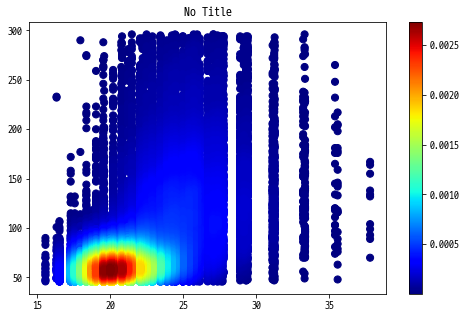

In [138]:
test.show_density_plt('BMI', '트리글리세라이드')

# Filter by Range(%)

In [29]:
filter_range_dict = {  # 'feature': 'MIN%~MAX%' to filter outlier
    '총콜레스테롤': '5%~95%',
    '트리글리세라이드': '5%~95%',
    'LDL콜레스테롤': '5%~95%',
    'HDL콜레스테롤': '5%~95%',
    '감마지티피': '5%~95%',
    '혈색소': '5%~95%',
    '(혈청지오티)ALT': '5%~95%',
    '(혈청지오티)AST': '5%~95%',
    '신장(5Cm단위)': '5%~95%',
    '체중(5Kg단위)': '5%~95%',
    '식전혈당(공복혈당)': '5%~95%'
}
new_test_range = ReadData(2017)
new_test_range.read(list(filter_range_dict.keys()), return_data=False, keep_FBS=True, calculate_BMI=False,
                   FBS_PIVOT = 120, FBS_MARGIN=15)

Reading Year 2017
Reading Year 2017's data done
Size of X = 860,256, y = 860,256
당뇨병 판별 공복혈당 기준 수치 : <=105 or >=120
당뇨병 판별 환자 수 : 101,701명, 비당뇨병 판별수 : 758,555명

X has 11 features
Selected Features and Sample Data: 
['신장(5Cm단위)', '체중(5Kg단위)', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피']
Mean : [162.16, 62.8, 98.75, 194.85, 128.68, 57.26, 112.64, 14.19, 25.68, 25.14, 35.47]
[170.   75.   99.  193.   92.   48.  126.   17.1  21.   35.   40. ] , 정상
[165.   75.   98.  136.  104.   41.   74.   15.8  47.   32.   68. ] , 정상


In [30]:
new_test_range.set_data_range(filter_range_dict)

Filter by Range
Filtered 86,021 with range   5%~ 95%,  values are in 137.0 ~ 260.0 by 총콜레스테롤
Filtered 74,096 with range   5%~ 95%,  values are in 45.0  ~ 289.0 by 트리글리세라이드
Filtered 26,003 with range   5%~ 95%,  values are in 60.0  ~ 171.0 by LDL콜레스테롤
Filtered 55,259 with range   5%~ 95%,  values are in 36.0  ~  84.0 by HDL콜레스테롤
Filtered 55,215 with range   5%~ 95%,  values are in 10.0  ~ 100.0 by 감마지티피
Filtered 50,576 with range   5%~ 95%,  values are in 11.7  ~  16.6 by 혈색소
Filtered 37,433 with range   5%~ 95%,  values are in 10.0  ~  57.0 by (혈청지오티)ALT
Filtered 25,347 with range   5%~ 95%,  values are in 14.0  ~  45.0 by (혈청지오티)AST
Filtered 46,632 with range   5%~ 95%,  values are in 150.0 ~ 175.0 by 신장(5Cm단위)
Filtered 25,715 with range   5%~ 95%,  values are in 45.0  ~  85.0 by 체중(5Kg단위)
Filtered 29,811 with range   5%~ 95%,  values are in 78.0  ~ 142.0 by 식전혈당(공복혈당)

Filtered 512,133 by data range from 860,256. (59.53%)  Filterd X size : 348,123. 
당뇨병 판별 공복혈당 기준 수치 : <=105 or >=120

In [31]:
new_test_range.calculate_BMI()

In [189]:
print(*new_test_range.data_infos)

총콜레스테롤 트리글리세라이드 HDL콜레스테롤 LDL콜레스테롤 혈색소 (혈청지오티)AST (혈청지오티)ALT 감마지티피 BMI


In [33]:
new_test_range.balance_size()

After Balancing Size  
당뇨병 판별 환자 수 : 22,294명, 비당뇨병 판별수 : 22,294명 (총 44,588명 = 12.81%)



In [44]:
new_test_range.keep_FBS=False
new_test_range.remove_FBS()

In [45]:
print(new_test_range.data_infos, new_test_range.X.shape)

['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI'] (44588, 9)


# Show All Data of Each Outliers

In [232]:
soft_filter_dict = {  # 'feature': [MAX Pivot, MIN Pivot] to filter outlier
    '총콜레스테롤': [2000, 10],
    '트리글리세라이드': [700, 10],
    'LDL콜레스테롤': [2000, 10],
    'HDL콜레스테롤': [1000, 0],
    '허리둘레': [150, 30],
    '감마지티피': [900, 5],
    '혈색소': [25, 5],
    '(혈청지오티)ALT': [3000, 5],
    '(혈청지오티)AST': [3000, 5],
    '신장(5Cm단위)': [200, 140],
    '체중(5Kg단위)': [140, 30],
    '식전혈당(공복혈당)': [400, 30]
}
test = ReadData(2017)
test.read(list(soft_filter_dict.keys()), return_data=False, keep_FBS=True, FBS_PIVOT=125, calculate_BMI=False)
clear_output()
keys = list(soft_filter_dict.keys())
max_p = list(map(lambda x:x.pop(0), copy.deepcopy(list(soft_filter_dict.values()))))
km = list(zip(keys, max_p))
for feature, max_pivot in km:
    test.show_outliers(feature, max_pivot, not_diabetes_only=False, show_all=True, MAX_LEN=30)

Feature : 총콜레스테롤, Max Pivot : 2000, Size : 5 (0.0%)
총콜레스테롤 신장(5Cm단위) 체중(5Kg단위) 허리둘레 식전혈당(공복혈당) 트리글리세라이드 HDL콜레스테롤 LDL콜레스테롤 혈색소 (혈청지오티)AST (혈청지오티)ALT 감마지티피
      2344.0       160.0        50.0        94.0       220.0       215.0        47.0      2254.0        16.4        64.0        71.0        87.0
      2196.0       145.0        60.0        91.0       106.0       124.0        57.0      2114.0        13.5        24.0        24.0        24.0
      2067.0       155.0        70.0        85.0       126.0       109.0         2.0      2043.0        14.0        21.0        17.0        34.0
      2046.0       170.0        75.0        88.0       105.0        92.0         1.0      2026.0        16.1        30.0        41.0        25.0
      2033.0       160.0        65.0        82.0       100.0       136.0        72.0      1933.0        14.5        22.0        25.0        24.0
Feature : 트리글리세라이드, Max Pivot : 700, Size : 3632 (0.36%)
트리글리세라이드 신장(5Cm단위) 체중(5Kg단위) 허리둘레 식전혈당(공복혈당) 총콜레스테롤 HDL콜레스테롤 LDL

Feature : 감마지티피, Max Pivot : 900, Size : 393 (0.04%)
감마지티피 신장(5Cm단위) 체중(5Kg단위) 허리둘레 식전혈당(공복혈당) 총콜레스테롤 트리글리세라이드 HDL콜레스테롤 LDL콜레스테롤 혈색소 (혈청지오티)AST (혈청지오티)ALT
       999.0       135.0        35.0        77.5       101.0       176.0       203.0        55.0        80.0        13.0       151.0        55.0
       999.0       155.0        55.0        95.0       118.0       191.0       133.0       106.0        58.0        15.3       157.0       125.0
       999.0       175.0        70.0        85.0        97.0       315.0       961.0        36.0       151.0        13.3       132.0        67.0
       999.0       160.0        60.0        79.0       179.0       144.0       305.0        34.0        49.0        13.4       237.0        76.0
       999.0       150.0        55.0        83.0       106.0       215.0       102.0        78.0       116.0        14.5       251.0       659.0
       999.0       170.0        55.0        73.0        55.0       167.0        86.0        74.0        76.0        15.2

# Compare Soft Filter and Hard Filter

In [188]:
test_soft_filter = ReadData(2017)
test_soft_filter.read(list(soft_filter_dict.keys()), filter_dict=soft_filter_dict, return_data=False, keep_FBS=False, 
                     FBS_PIVOT=125, calculate_BMI=True, balance_size=True)

Reading Year 2017
Filtering outliers
Filtered     5 by 총콜레스테롤
Filtered 3,680 by 트리글리세라이드
Filtered   276 by LDL콜레스테롤
Filtered     1 by HDL콜레스테롤
Filtered    61 by 허리둘레
Filtered 1,478 by 감마지티피
Filtered    50 by 혈색소
Filtered 2,487 by (혈청지오티)ALT
Filtered   111 by (혈청지오티)AST
Filtered 10,568 by 신장(5Cm단위)
Filtered    45 by 체중(5Kg단위)
Filtered   212 by 식전혈당(공복혈당)
Filtered 18,974. Filterd X size : 977,829. (1.90%)

Reading Year 2017's data done
Size of X = 977,829, y = 977,829
당뇨병 판별 공복혈당 기준 수치 : 125
당뇨병 판별 환자 수 : 77,705명, 비당뇨병 판별수 : 900,124명

After Balancing Size  
당뇨병 판별 환자 수 : 77,705명, 비당뇨병 판별수 : 77,705명 (총 155,410명 = 15.89%)

X has 10 features
Selected Features and Sample Data: 
['허리둘레', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
Mean : [ 83.65537031 192.26213886 147.77687408  54.51386655 109.17994981
  14.37779229  28.0221543   29.32156232  46.15484847  24.57063104]
[ 98.   115.   137.    31.    57.    16.5   48.    51.    42.    31.22] ,

In [189]:
soft_filter_LR = DiabetesModelingLR()
soft_filter_LR.make_model(X=test_soft_filter.X, y=test_soft_filter.y)
clear_output()

In [190]:
soft_filter_LR.show_result()

Training size : 124,328 Testing Size : 31,082
Test Set 당뇨병 인원수 : 15,541명, 비당뇨병 인원수 : 15,541명

Accuracy score: 0.66826       F1 Score: 0.6705

              precision    recall  f1-score   support

          건강       0.67      0.66      0.67     15541
          당뇨       0.67      0.68      0.67     15541

    accuracy                           0.67     31082
   macro avg       0.67      0.67      0.67     31082
weighted avg       0.67      0.67      0.67     31082

Confusion Matrix
 [[10280  5261]
 [ 5050 10491]]


In [221]:
hard_filter_dict = {  # 'feature': [MAX Pivot, MIN Pivot] to filter outlier
    '총콜레스테롤': [500, 10],
    '트리글리세라이드': [1000, 30],
    'LDL콜레스테롤': [500, 30],
    'HDL콜레스테롤': [100, 3],
    '허리둘레': [150, 30],
    '감마지티피': [300, 5],
    '혈색소': [19, 5],
    '(혈청지오티)ALT': [200, 5],
    '(혈청지오티)AST': [200, 5],
    '신장(5Cm단위)': [200, 140],
    '체중(5Kg단위)': [140, 30],
    '식전혈당(공복혈당)': [500, 30]
}
test_hard_filter = ReadData(2017)
test_hard_filter.read(list(hard_filter_dict.keys()), return_data=False, filter_dict=hard_filter_dict, keep_FBS=False, 
                      FBS_PIVOT=125, calculate_BMI=True, balance_size=True)

Reading Year 2017
Filtering outliers
Filtered    62 by 총콜레스테롤
Filtered 3,647 by 트리글리세라이드
Filtered   302 by LDL콜레스테롤
Filtered 9,895 by HDL콜레스테롤
Filtered    53 by 허리둘레
Filtered 6,378 by 감마지티피
Filtered   396 by 혈색소
Filtered 3,586 by (혈청지오티)ALT
Filtered   413 by (혈청지오티)AST
Filtered 10,455 by 신장(5Cm단위)
Filtered    41 by 체중(5Kg단위)
Filtered   205 by 식전혈당(공복혈당)
Filtered 35,433. Filterd X size : 961,370. (3.55%)

Reading Year 2017's data done
Size of X = 961,370, y = 961,370
당뇨병 판별 공복혈당 기준 수치 : 125
당뇨병 판별 환자 수 : 75,729명, 비당뇨병 판별수 : 885,641명

After Balancing Size  
당뇨병 판별 환자 수 : 75,729명, 비당뇨병 판별수 : 75,729명 (총 151,458명 = 15.75%)

X has 10 features
Selected Features and Sample Data: 
['허리둘레', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
Mean : [ 83.68639227 191.94473715 147.33200623  54.03980641 109.36525637
  14.37255411  27.10617465  28.44085489  41.64986333  24.58905201]
[ 98.   115.   137.    31.    57.    16.5   48.    51.    42.    31.22] ,

In [222]:
hard_filter_LR = DiabetesModelingLR()
hard_filter_LR.make_model(X=test_hard_filter.X, y=test_hard_filter.y)
clear_output()
hard_filter_LR.show_result()

Training size : 121,166 Testing Size : 30,292
Test Set 당뇨병 인원수 : 15,146명, 비당뇨병 인원수 : 15,146명

Accuracy score: 0.6647       F1 Score: 0.66673

              precision    recall  f1-score   support

          건강       0.67      0.66      0.66     15146
          당뇨       0.66      0.67      0.67     15146

    accuracy                           0.66     30292
   macro avg       0.66      0.66      0.66     30292
weighted avg       0.66      0.66      0.66     30292

Confusion Matrix
 [[ 9975  5171]
 [ 4986 10160]]


In [236]:
print('Coefficients')
print('%15s %15s %15s'%('Feature', 'Soft Filter', 'Hard Filter'))
for i in range(len(test_soft_filter.data_infos)):
    print(f'{test_soft_filter.data_infos[i]:<15}', 
          f'{soft_filter_LR.clf.coef_[0][i]:<15.5}',
          f'{hard_filter_LR.clf.coef_[0][i]:<15.5}')
print(f'F1 Score : {soft_filter_LR.get_f1_score():15.3}  {hard_filter_LR.get_f1_score():15.3}')

Coefficients
        Feature     Soft Filter     Hard Filter
허리둘레            0.59354         0.5662         
총콜레스테롤          0.0             0.0            
트리글리세라이드        0.21694         0.19987        
HDL콜레스테롤        -0.20738        -0.2136        
LDL콜레스테롤        -0.33478        -0.33722       
혈색소             0.0             0.0            
(혈청지오티)AST      0.0094333       0.023117       
(혈청지오티)ALT      0.046746        0.054674       
감마지티피           0.13987         0.18305        
BMI             0.0             0.0            
F1 Score :           0.671            0.667


In [86]:
filter_dict = {  # 'feature': [MAX Pivot, MIN Pivot] to filter outlier
    '총콜레스테롤': [500, 10],
    '트리글리세라이드': [700, 10],
    'LDL콜레스테롤': [500, 10],
    '허리둘레': [150, 30],
    '감마지티피': [300, 5],
    '혈색소': [19, 5],
    '(혈청지오티)ALT': [200, 5],
    '(혈청지오티)AST': [200, 5],
    '신장(5Cm단위)': [200, 140],
    '체중(5Kg단위)': [140, 30],
    '식전혈당(공복혈당)': [400, 30]
}

Reading Year 2017
Reading Year 2017's data done
Size of X = 49,848, y = 49,848
당뇨병 판별 공복혈당 기준 수치 : 140
당뇨병 판별 환자 수 : 2,393명, 비당뇨병 판별수 : 47,455명

X has 10 features
Selected Features and Sample Data: 
['허리둘레', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
[ 90.    99.   193.    92.   126.    17.1   21.    35.    40.    25.95] , 정상
[ 89.   106.   228.   121.   148.    15.8   20.    36.    27.    24.69] , 정상


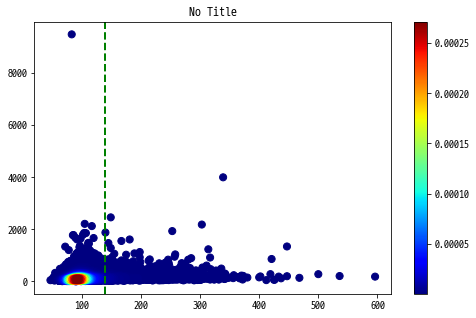

In [4]:
not_filtered = ReadData(2017)
not_filtered.read(list(filter_dict.keys()), FBS_PIVOT=140,
                  return_data=False, keep_FBS=True, DATASIZE=50000)
# clear_output()

not_filtered.show_density_plt('식전혈당(공복혈당)', '트리글리세라이드')

Reading Year 2017
Filtering outliers
Filtered     3 by 총콜레스테롤
Filtered   179 by 트리글리세라이드
Filtered    15 by LDL콜레스테롤
Filtered     3 by 허리둘레
Filtered   306 by 감마지티피
Filtered     9 by 혈색소
Filtered   193 by (혈청지오티)ALT
Filtered    28 by (혈청지오티)AST
Filtered   511 by 신장(5Cm단위)
Filtered     3 by 체중(5Kg단위)
Filtered    13 by 식전혈당(공복혈당)
Filtered 1,263. Filterd X size : 48,585. (2.53%)

Reading Year 2017's data done
Size of X = 48,585, y = 48,585
당뇨병 판별 공복혈당 기준 수치 : 140
당뇨병 판별 환자 수 : 2,237명, 비당뇨병 판별수 : 46,348명

X has 10 features
Selected Features and Sample Data: 
['허리둘레', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
[ 90.    99.   193.    92.   126.    17.1   21.    35.    40.    25.95] , 정상
[ 89.   106.   228.   121.   148.    15.8   20.    36.    27.    24.69] , 정상


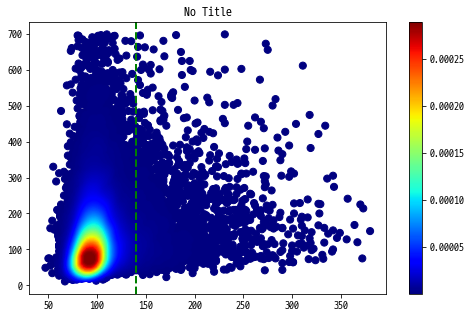

In [5]:
filtered = ReadData(2017)
filtered.read(list(filter_dict.keys()), FBS_PIVOT=140, filter_dict=filter_dict,
              return_data=False, keep_FBS=True, DATASIZE=50000)
# clear_output()

filtered.show_density_plt('식전혈당(공복혈당)', '트리글리세라이드')

# Read Data

In [4]:
data2017 = ReadData(2017)
data2017.show_params()

selected_features=<class 'inspect._empty'> DATASIZE=None FBS_PIVOT=120 calculate_BMI=True return_data=True count_empty_data=False filter_dict=None keep_FBS=False balance_size=False


In [335]:
# t = ReadData(2017)
# t.read(selected_features, FBS_PIVOT=140, filter_dict=filter_dict, return_data=False, keep_FBS=True,
#          DATASIZE=100)
# clear_output()
# test.show_density_plt('총콜레스테롤', '트리글리세라이드')

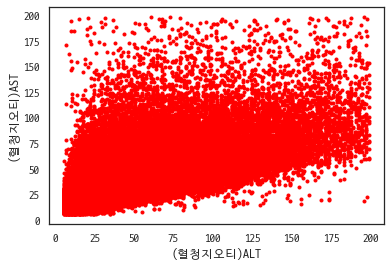

In [336]:
test = ReadData(2017)
test.read(selected_features, FBS_PIVOT=140,
          filter_dict=filter_dict, return_data=False, keep_FBS=True)
clear_output()
test.show_plt('(혈청지오티)ALT', '(혈청지오티)AST')

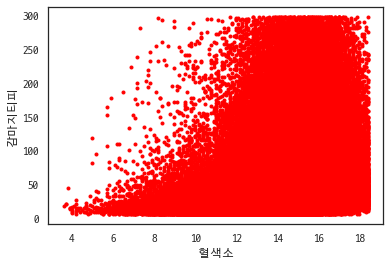

In [337]:
test.show_plt('혈색소', '감마지티피')

In [340]:
# {'총콜레스테롤': [500, 10],
#  '트리글리세라이드': [700, 10],
#  'LDL콜레스테롤': [500, 10],
#  '허리둘레': [150, 30],
#  '감마지티피': [300, 5],
#  '혈색소': [18.5, 3],
#  '(혈청지오티)ALT': [200, 5],
#  '(혈청지오티)AST': [200, 5],
#  '신장(5Cm단위)': [200, 140],
#  '체중(5Kg단위)': [140, 30],
#  '식전혈당(공복혈당)': [300, 30]}

In [5]:
filter_dict = {  # 'feature': [MAX Pivot, MIN Pivot] to filter outlier
    '총콜레스테롤': [500, 10],
    '트리글리세라이드': [700, 10],
    'LDL콜레스테롤': [500, 10],
    '허리둘레': [150, 30],
    '감마지티피': [300, 5],
    '혈색소': [19, 5],
    '(혈청지오티)ALT': [200, 5],
    '(혈청지오티)AST': [200, 5],
    '신장(5Cm단위)': [200, 140],
    '체중(5Kg단위)': [140, 30],
    '식전혈당(공복혈당)': [400, 30]
}
selected_features = list(filter_dict.keys())
data2017 = ReadData(2017)
# selected_features = Features to read, DATASIZE = Data size limit, FBS_PIVOT = 당노병 판단 기준 혈당
# calculate_BMI = 체중, 키를 BMI지수로 환산, return_data = return X,y for variable
# count_empty_data = count data with empty value
data2017.read(selected_features, FBS_PIVOT=125, filter_dict=filter_dict, return_data=False,
              balance_size=True)

Reading Year 2017
Filtering outliers
Filtered    62 by 총콜레스테롤
Filtered 3,647 by 트리글리세라이드
Filtered   302 by LDL콜레스테롤
Filtered    61 by 허리둘레
Filtered 6,584 by 감마지티피
Filtered   398 by 혈색소
Filtered 3,620 by (혈청지오티)ALT
Filtered   424 by (혈청지오티)AST
Filtered 10,532 by 신장(5Cm단위)
Filtered    44 by 체중(5Kg단위)
Filtered   207 by 식전혈당(공복혈당)
Filtered 25,881. Filterd X size : 970,922. (2.60%)

Reading Year 2017's data done
Size of X = 970,922, y = 970,922
당뇨병 판별 공복혈당 기준 수치 : 125
당뇨병 판별 환자 수 : 76,086명, 비당뇨병 판별수 : 894,836명

After Balancing Size  
당뇨병 판별 환자 수 : 76,086명, 비당뇨병 판별수 : 76,086명 (총 152172명 = 15.67%)

X has 9 features
Selected Features and Sample Data: 
['허리둘레', '총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
[ 98.   115.   137.    57.    16.5   48.    51.    42.    31.22] , 당뇨
[ 77.   181.   206.    89.    14.5   22.    19.    48.    22.22] , 당뇨


# Feature Importance (Random Forest Classifier)

In [68]:
labels=[
    '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', '혈색소', 
    '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']

 1) (혈청지오티)AST                     0.285880
 2) (혈청지오티)ALT                     0.210396
 3) 트리글리세라이드                       0.167767
 4) 총콜레스테롤                         0.130759
 5) 혈색소                            0.109824
 6) 감마지티피                          0.062935
 7) LDL콜레스테롤                       0.021852
 8) HDL콜레스테롤                       0.010587


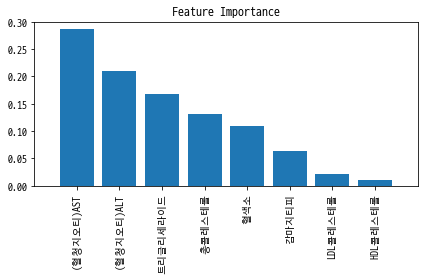

In [70]:
feat_labels = np.array(test.data_infos[:])
forest = RandomForestClassifier(n_estimators=500, random_state=42)
X_train, X_test, y_train, y_test = split_set(test.get_specific_data(labels), test.y)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center') 
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], 
           rotation=90)
plt.xlim([-1, X_train.shape[1]]) 
plt.tight_layout()
plt.show()

# Visualization

# Features with Balanced Pick
### Diabetes Only

In [166]:
t = [test.X[i] for i in range(len(test.X)) if test.y[i] == 0]

In [185]:
features=['총콜레스테롤',
         '트리글리세라이드',
         'HDL콜레스테롤',
         'LDL콜레스테롤',
         '혈색소',
         '(혈청지오티)AST',
         '(혈청지오티)ALT',
         '감마지티피']
t = [test.X[i] for i in range(len(test.X)) if test.y[i] == 1]
tt.X = np.array(t[:])

In [186]:
tt.X.shape

(12260, 9)

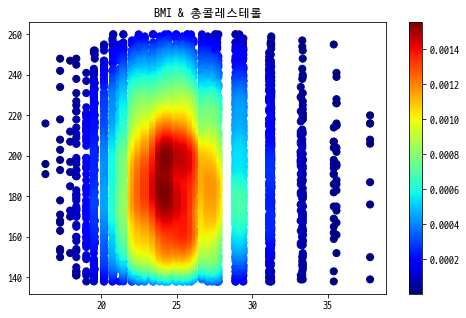

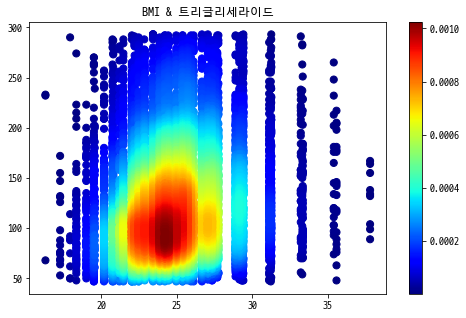

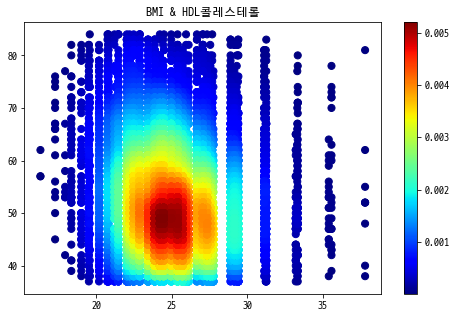

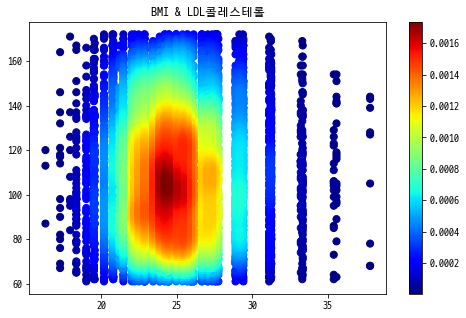

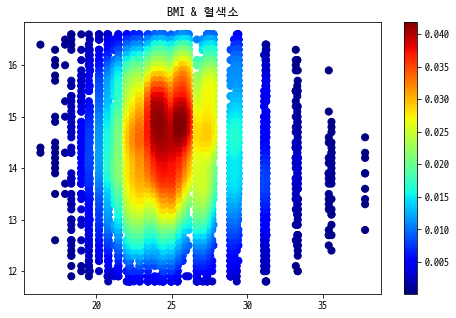

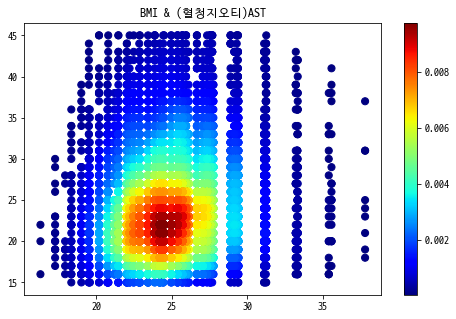

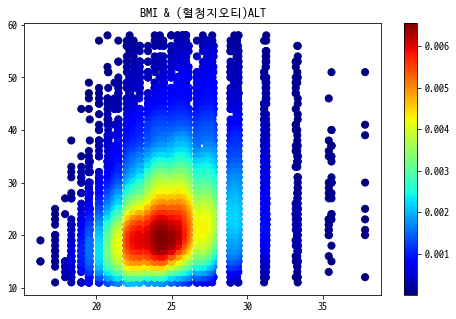

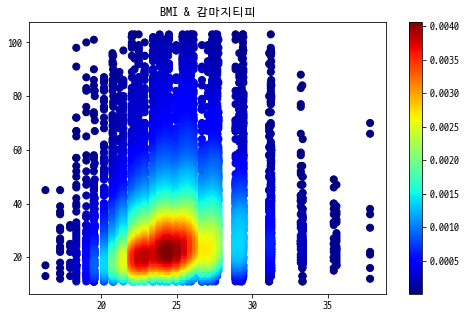

In [187]:
for feature in features:
    tt.show_density_plt('BMI', feature, title='BMI'+' & '+feature)

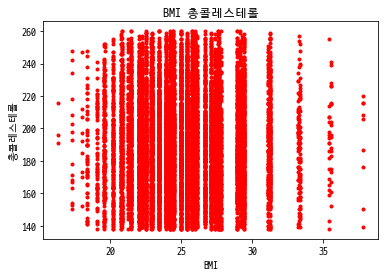

<ipython-input-65-712308b64001>:426: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


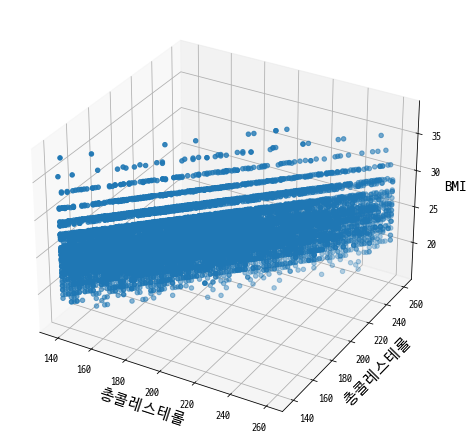

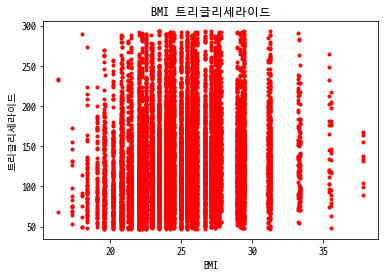

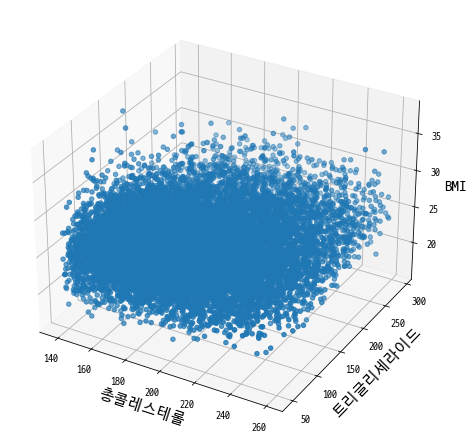

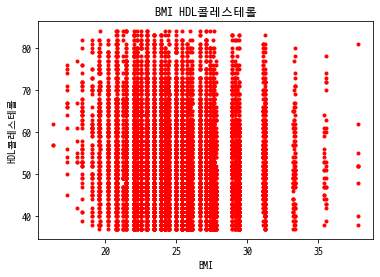

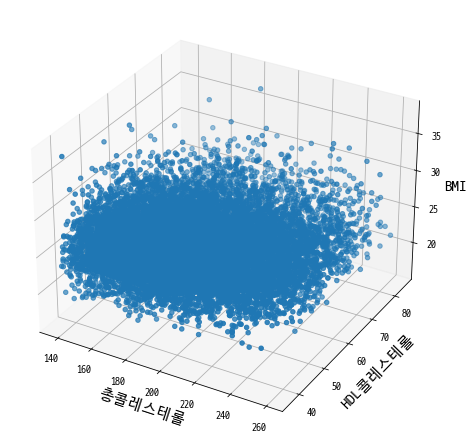

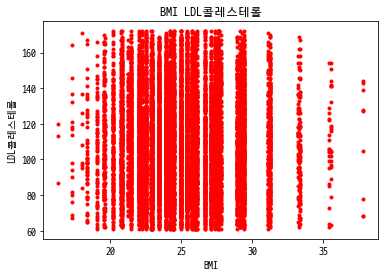

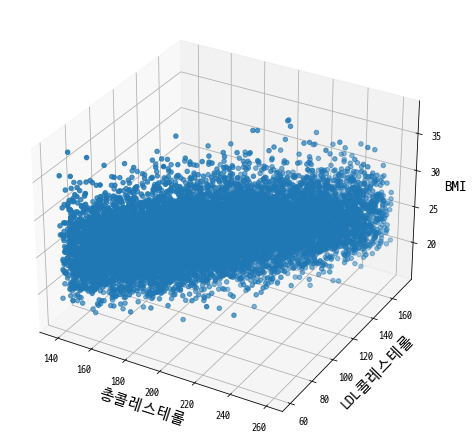

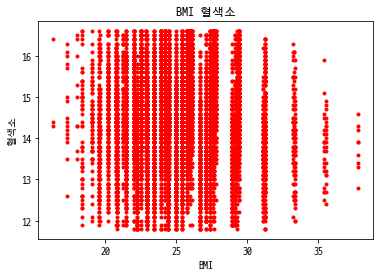

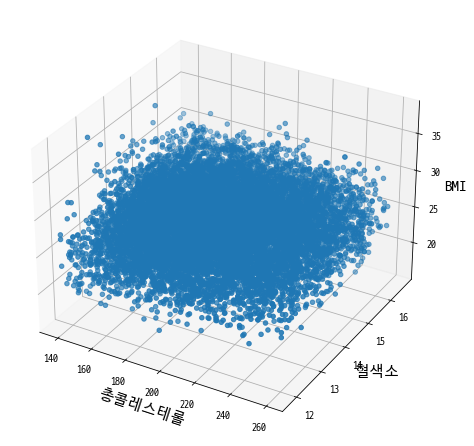

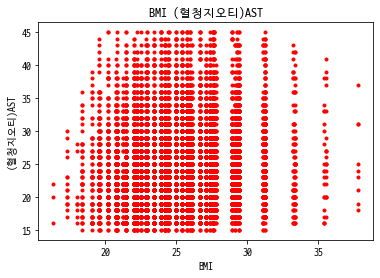

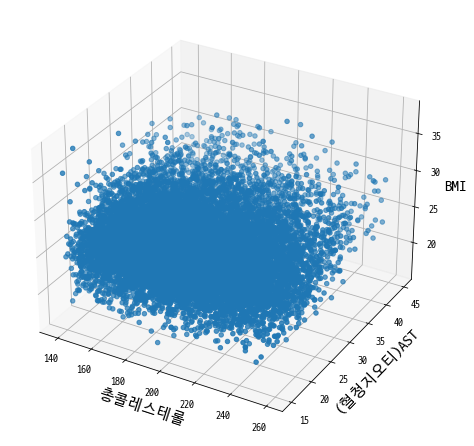

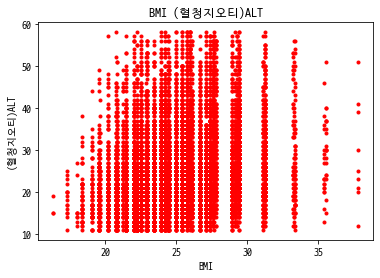

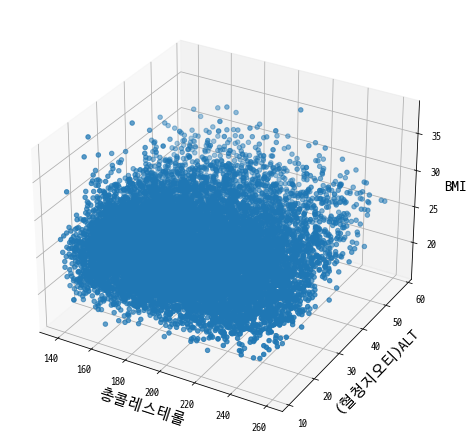

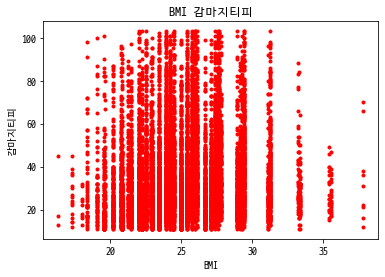

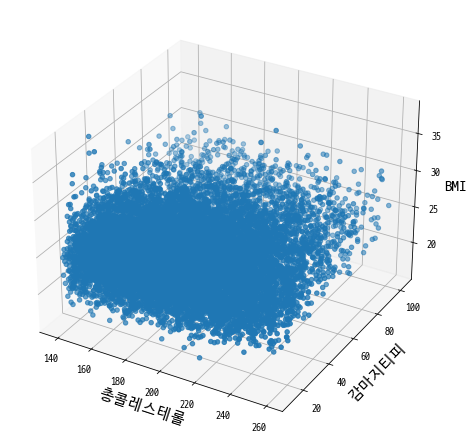

In [188]:
for feature in features:
    tt.show_plt('BMI', feature, title='BMI' + ' ' + feature)
    tt.show_3D_plt('총콜레스테롤', feature, 'BMI')

# Features with Balanced Pick
### Not Diabetes Only

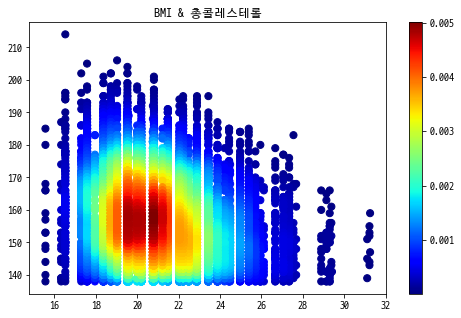

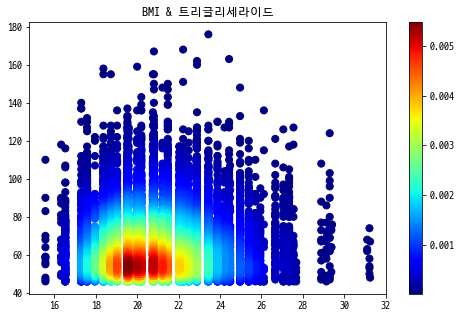

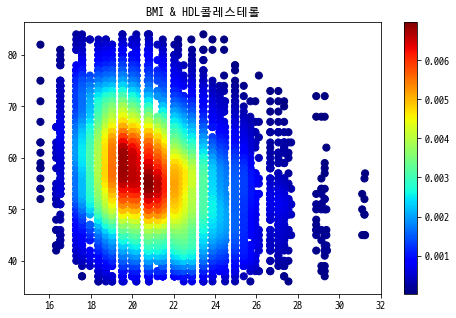

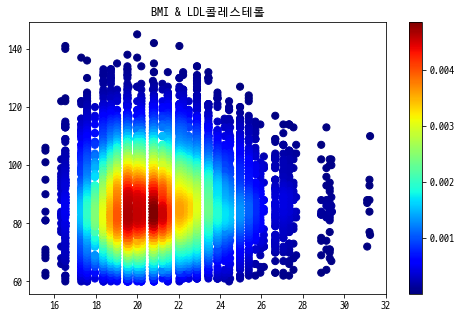

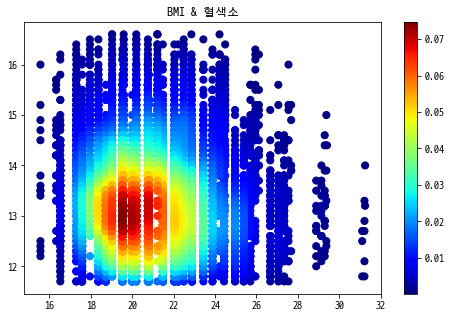

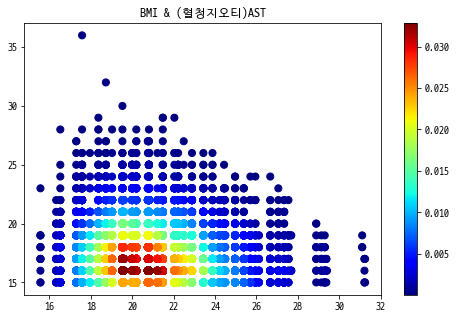

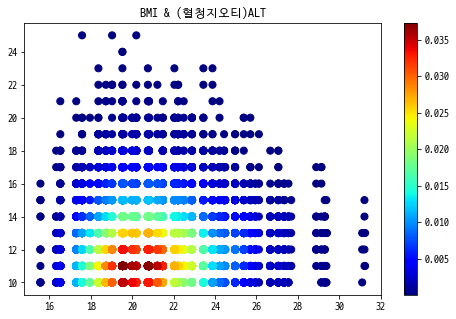

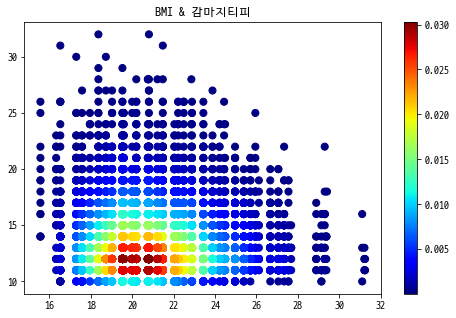

In [184]:
for feature in features:
    tt.show_density_plt('BMI', feature, title='BMI'+' & '+feature)

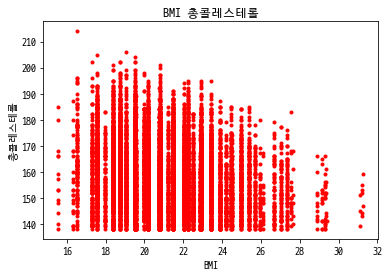

<ipython-input-65-712308b64001>:426: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


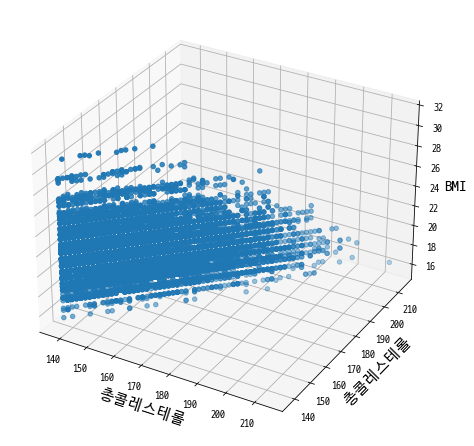

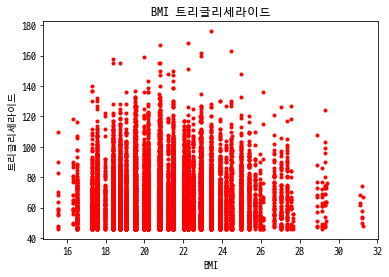

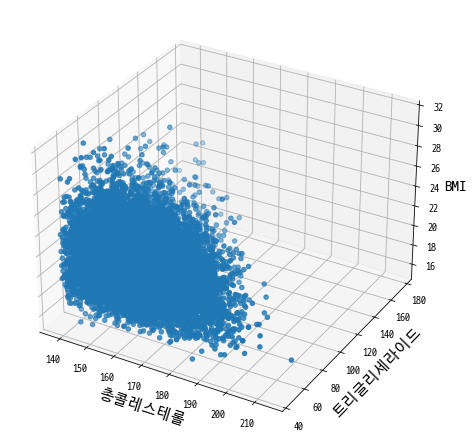

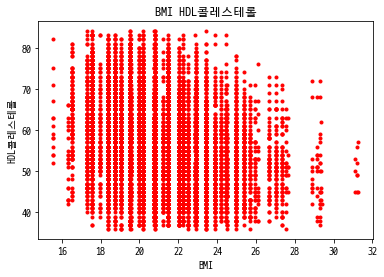

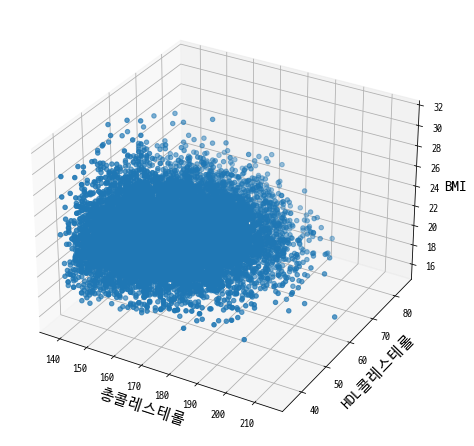

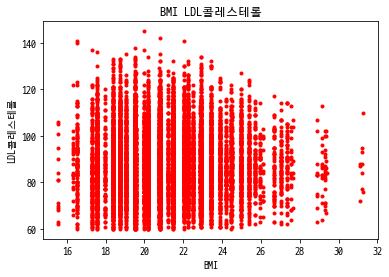

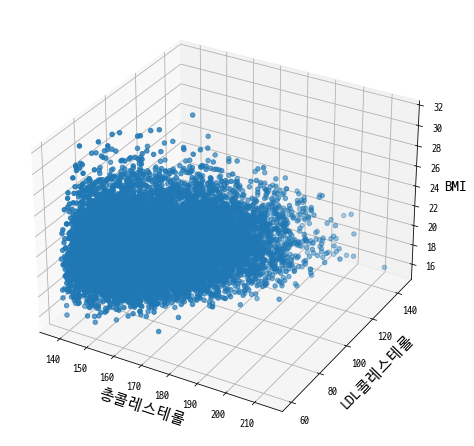

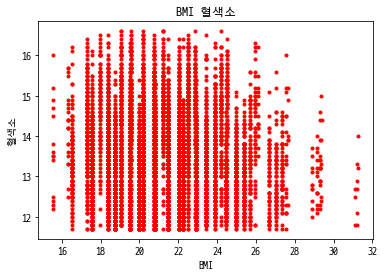

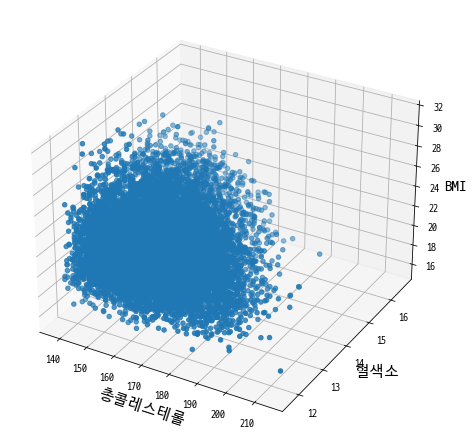

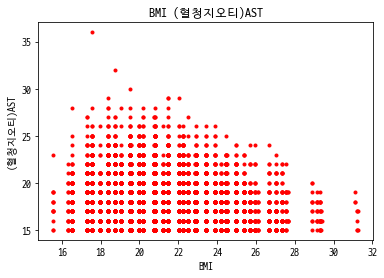

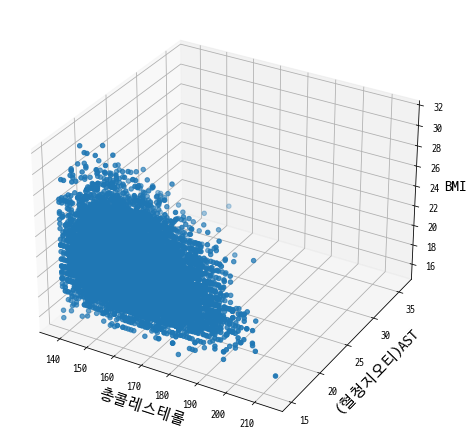

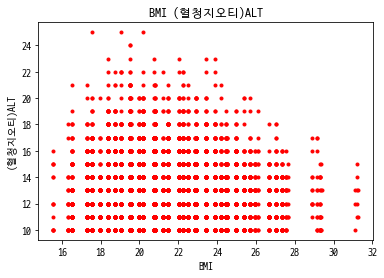

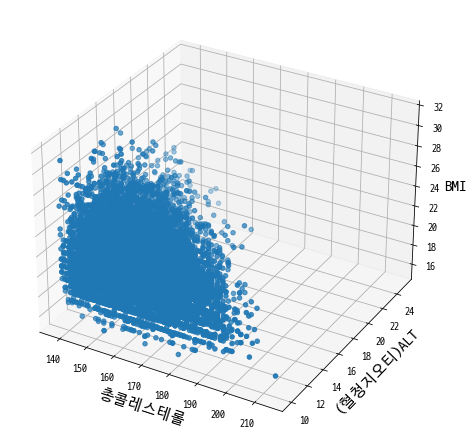

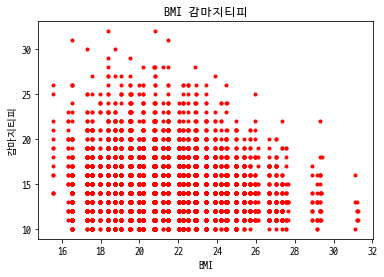

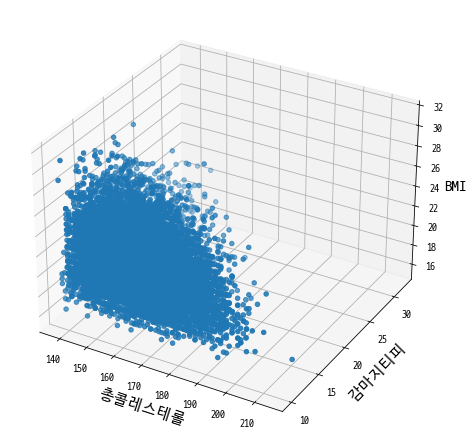

In [183]:
for feature in features:
    tt.show_plt('BMI', feature, title='BMI' + ' ' + feature)
    tt.show_3D_plt('총콜레스테롤', feature, 'BMI')

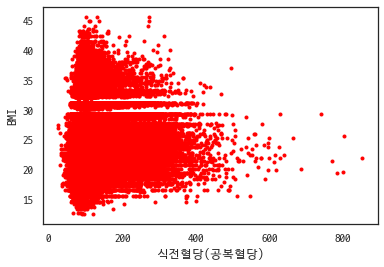

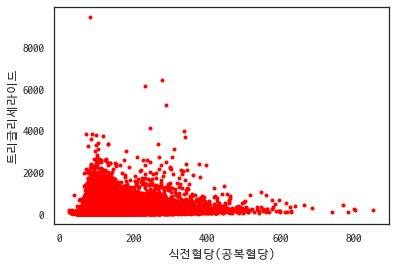

In [149]:
# before filtering
no_filter = ReadData(2017)
no_filter.read(selected_features, FBS_PIVOT=140,
               return_data=False, keep_FBS=True)
clear_output()
no_filter.show_plot('식전혈당(공복혈당)', 'BMI')
no_filter.show_plot('식전혈당(공복혈당)', '트리글리세라이드')

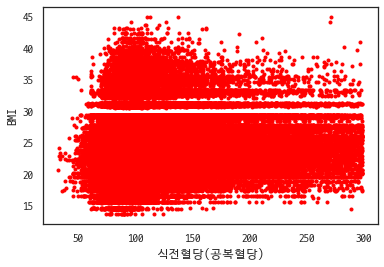

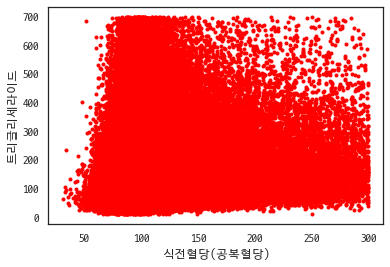

In [148]:
# after filtering
filtered = ReadData(2017)
filtered.read(selected_features, FBS_PIVOT=140,
              filter_dict=filter_dict, return_data=False, keep_FBS=True)
clear_output()
filtered.show_plot('식전혈당(공복혈당)', 'BMI')
filtered.show_plot('식전혈당(공복혈당)', '트리글리세라이드')

# Filtered Plots

In [8]:
filtered = ReadData(2017)
filtered.read(list(filter_dict.keys()), FBS_PIVOT=140, filter_dict=filter_dict,
              return_data=False, keep_FBS=True)

Reading Year 2017
Filtering outliers
Filtered    62 by 총콜레스테롤
Filtered 3,647 by 트리글리세라이드
Filtered   302 by LDL콜레스테롤
Filtered    61 by 허리둘레
Filtered 6,584 by 감마지티피
Filtered   398 by 혈색소
Filtered 3,620 by (혈청지오티)ALT
Filtered   424 by (혈청지오티)AST
Filtered 10,532 by 신장(5Cm단위)
Filtered    44 by 체중(5Kg단위)
Filtered   207 by 식전혈당(공복혈당)
Filtered 25,881. Filterd X size : 970,922. (2.60%)

Reading Year 2017's data done
Size of X = 970,922, y = 970,922
당뇨병 판별 공복혈당 기준 수치 : 140
당뇨병 판별 환자 수 : 43,201명, 비당뇨병 판별수 : 927,721명

X has 10 features
Selected Features and Sample Data: 
['허리둘레', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
[ 90.    99.   193.    92.   126.    17.1   21.    35.    40.    25.95] , 정상
[ 89.   106.   228.   121.   148.    15.8   20.    36.    27.    24.69] , 정상


In [ ]:
fbs = '식전혈당(공복혈당)'
features = ['허리둘레',
            '총콜레스테롤', '트리글리세라이드',
            'LDL콜레스테롤', '혈색소',
            '(혈청지오티)AST', '(혈청지오티)ALT',
            '감마지티피', 'BMI']

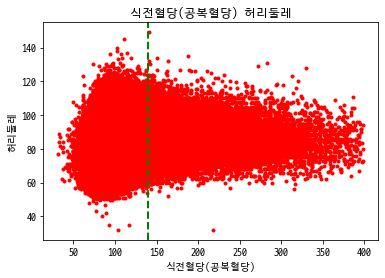

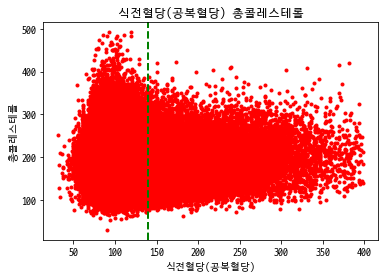

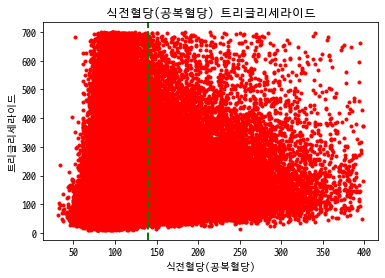

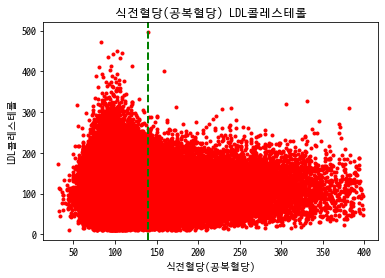

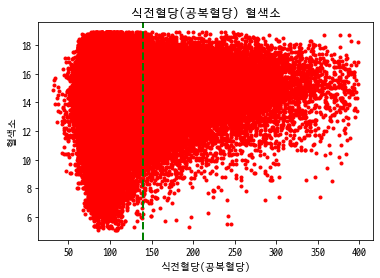

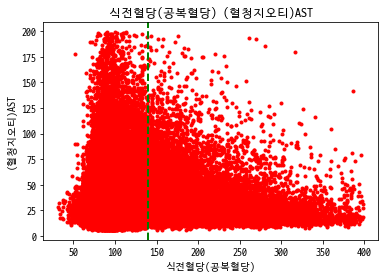

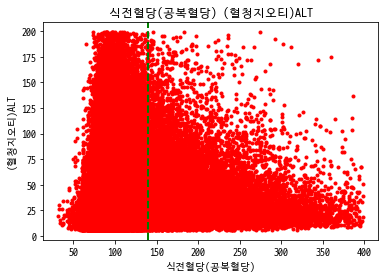

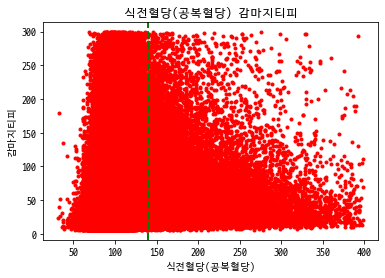

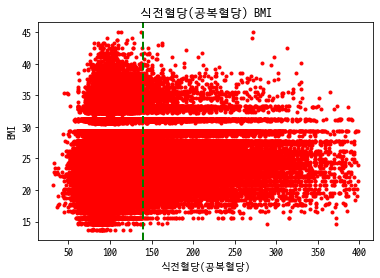

In [10]:
for feature in features:
    filtered.show_plt(fbs, feature, title=fbs+' '+feature)
#     filtered.show_density_plt(fbs, feature, title=fbs+' '+feature)

<ipython-input-2-95213675fc36>:344: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


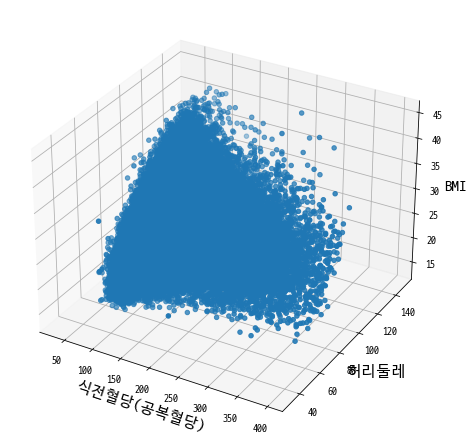

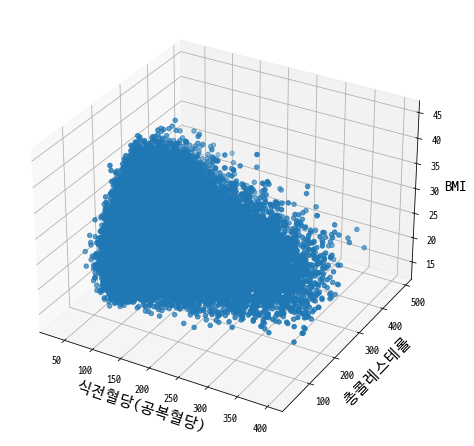

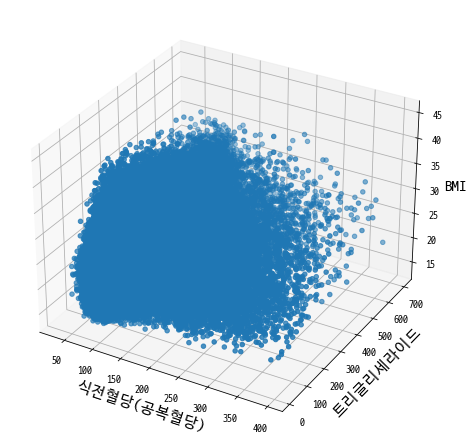

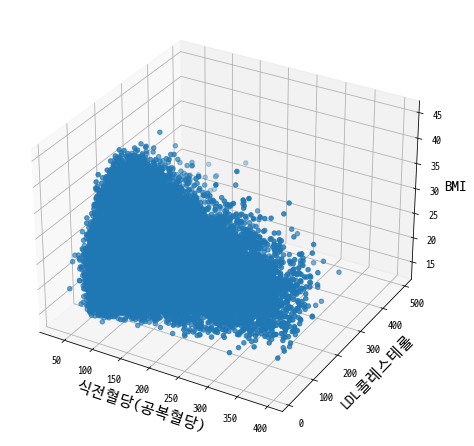

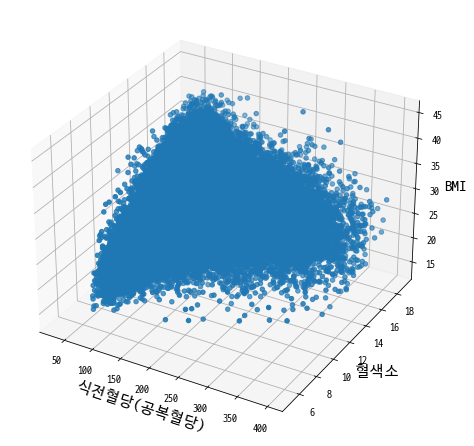

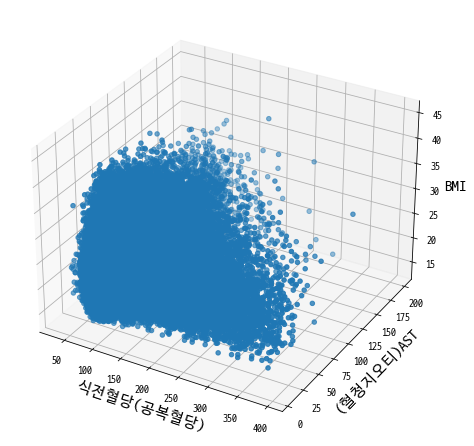

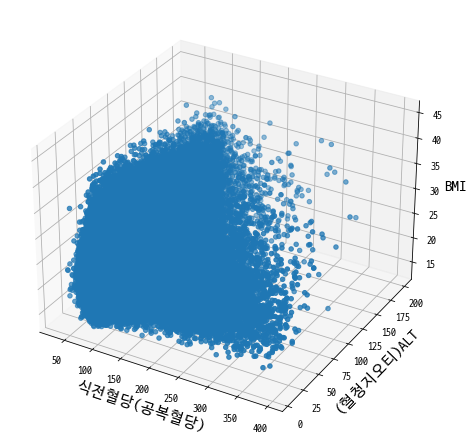

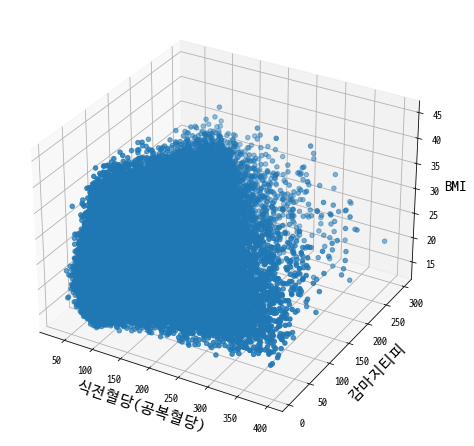

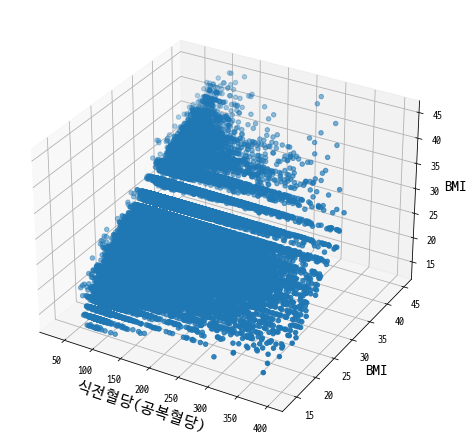

In [12]:
for feature in features:
    filtered.show_3D_plt(fbs, feature, 'BMI')

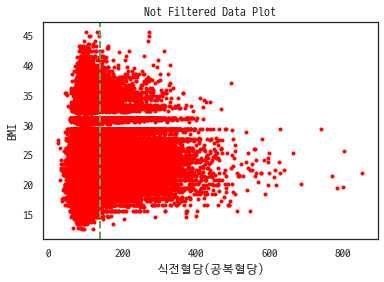

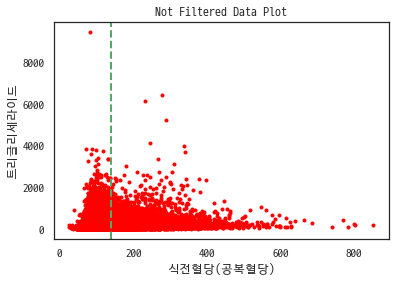

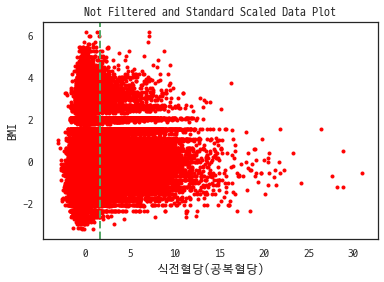

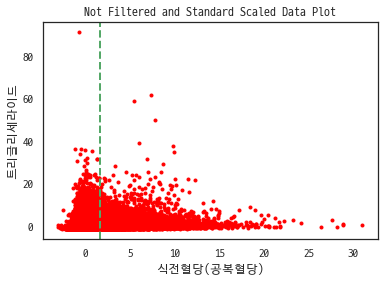

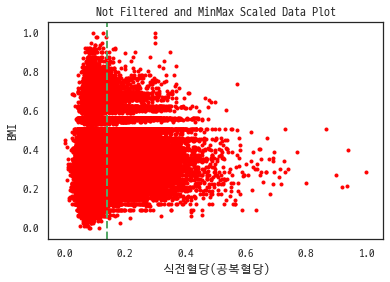

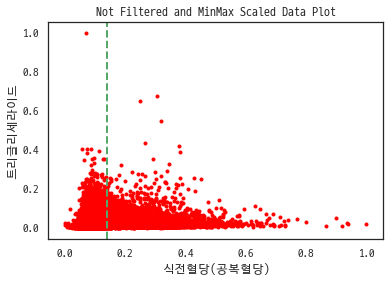

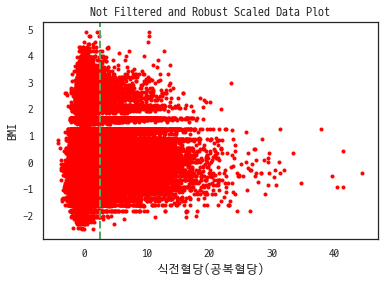

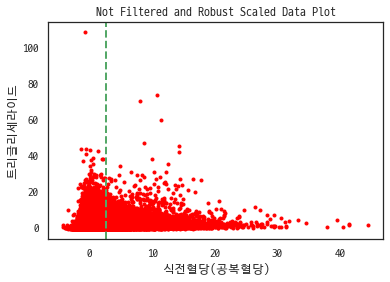

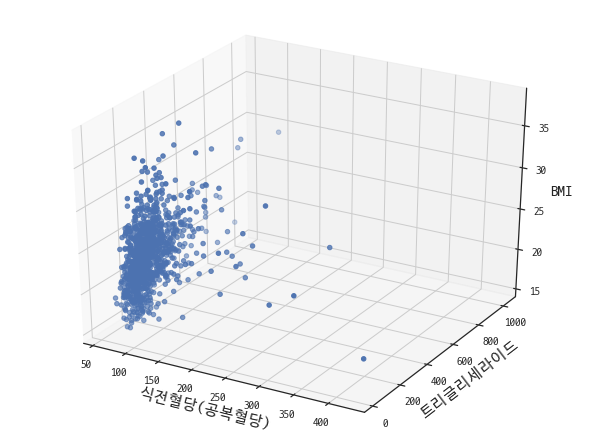

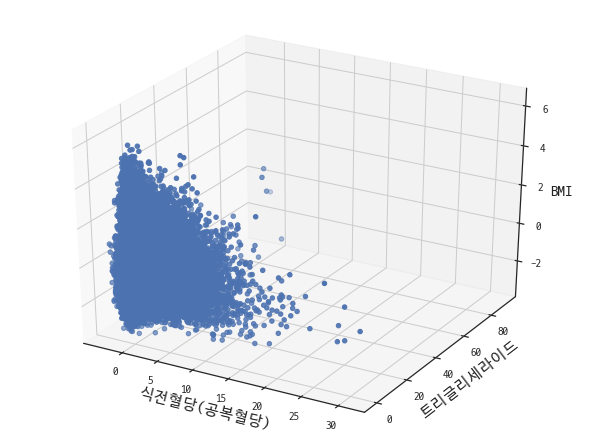

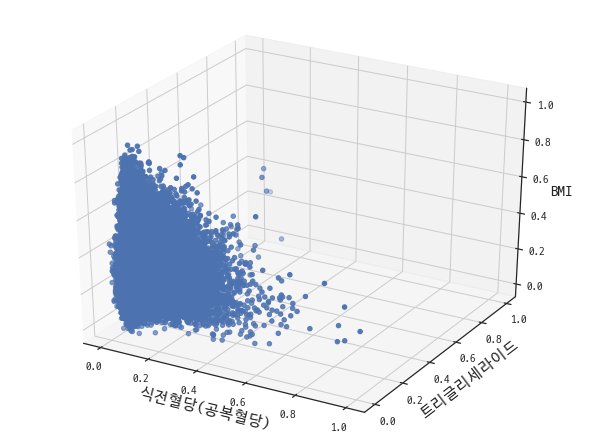

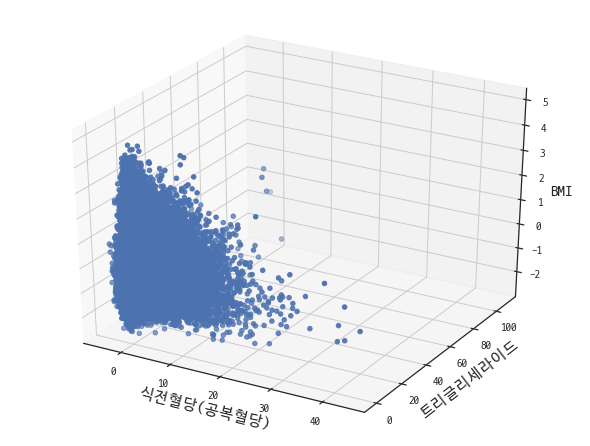

In [306]:
not_filtered.show_plt('식전혈당(공복혈당)', 'BMI',
                      title='Not Filtered Data Plot')
not_filtered.show_plt('식전혈당(공복혈당)', '트리글리세라이드',
                      title='Not Filtered Data Plot')

not_filtered.show_plt('식전혈당(공복혈당)', 'BMI', scaler='Standard',
                      title='Not Filtered and Standard Scaled Data Plot')
not_filtered.show_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='Standard',
                      title='Not Filtered and Standard Scaled Data Plot')

not_filtered.show_plt('식전혈당(공복혈당)', 'BMI', scaler='MinMax',
                      title='Not Filtered and MinMax Scaled Data Plot')
not_filtered.show_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='MinMax',
                      title='Not Filtered and MinMax Scaled Data Plot')

not_filtered.show_plt('식전혈당(공복혈당)', 'BMI', scaler='Robust',
                      title='Not Filtered and Robust Scaled Data Plot')
not_filtered.show_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='Robust',
                      title='Not Filtered and Robust Scaled Data Plot')


not_filtered.show_3D_plt('식전혈당(공복혈당)', '트리글리세라이드', 'BMI')
not_filtered.show_3D_plt('식전혈당(공복혈당)', '트리글리세라이드', 'BMI', scaler='Standard')
not_filtered.show_3D_plt('식전혈당(공복혈당)', '트리글리세라이드', 'BMI', scaler='MinMax')
not_filtered.show_3D_plt('식전혈당(공복혈당)', '트리글리세라이드', 'BMI', scaler='Robust')


not_filtered.show_density_plt('식전혈당(공복혈당)', '트리글리세라이드')

In [ ]:
not_filtered = ReadData(2017)
not_filtered.read(list(filter_dict.keys()), FBS_PIVOT=140,
                  return_data=False, keep_FBS=True, DATASIZE=100)
clear_output()

not_filtered.show_density_plt('식전혈당(공복혈당)', '트리글리세라이드')
not_filtered.show_density_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='Standard')
not_filtered.show_density_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='MinMax')
not_filtered.show_density_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='Robust')

## Filtered Plots

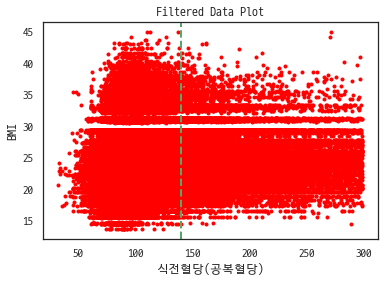

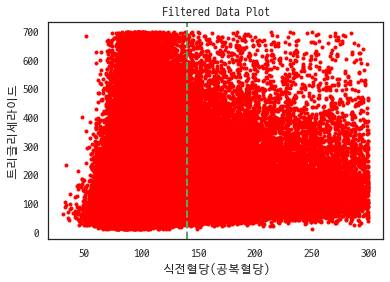

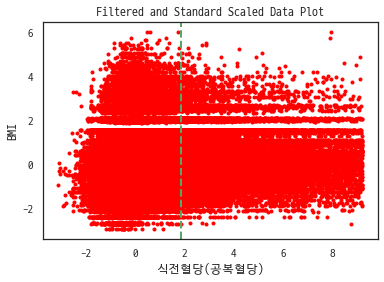

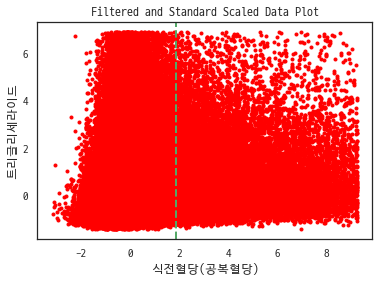

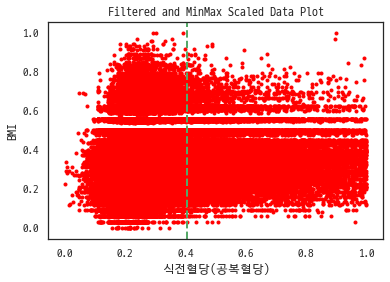

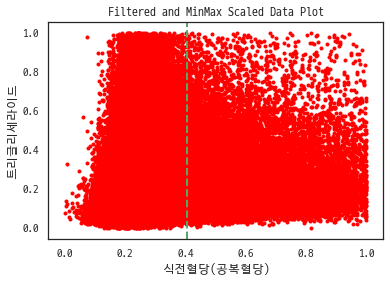

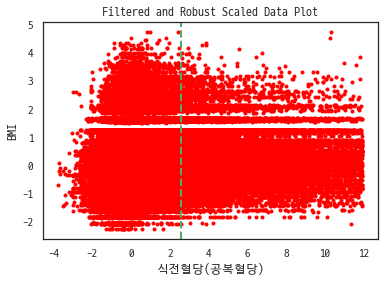

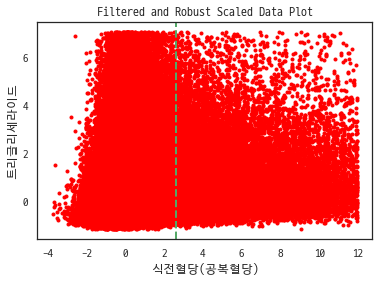

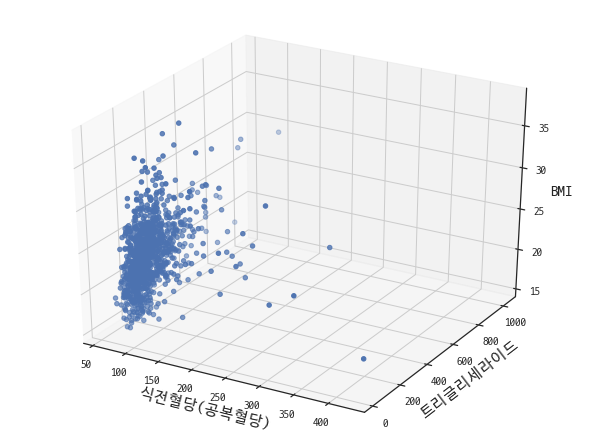

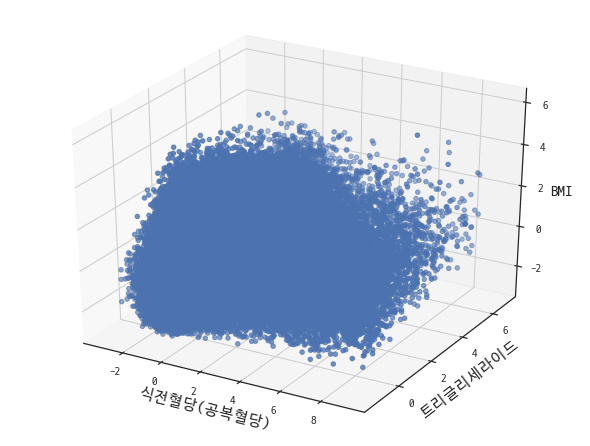

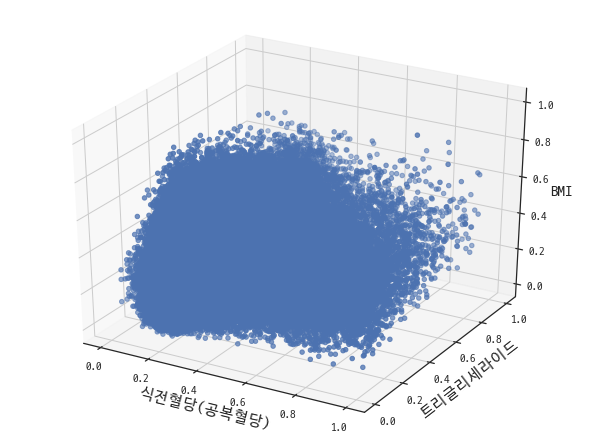

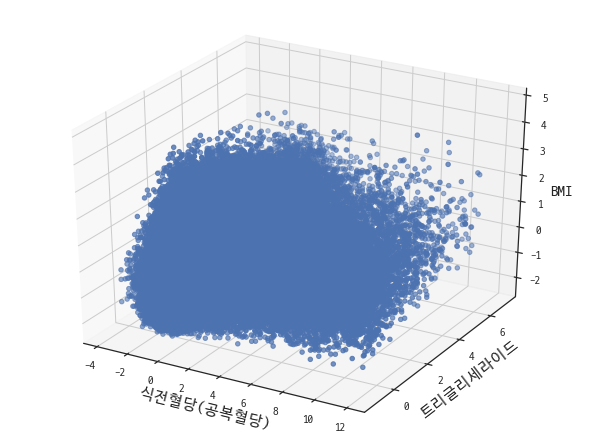

KeyboardInterrupt: 

In [327]:
filtered = ReadData(2017)
filtered.read(list(filter_dict.keys()), FBS_PIVOT=140,
              filter_dict=filter_dict, return_data=False, keep_FBS=True)
clear_output()

filtered.show_plt('식전혈당(공복혈당)', 'BMI',
                  title='Filtered Data Plot')
filtered.show_plt('식전혈당(공복혈당)', '트리글리세라이드',
                  title='Filtered Data Plot')

filtered.show_plt('식전혈당(공복혈당)', 'BMI', scaler='Standard',
                  title='Filtered and Standard Scaled Data Plot')
filtered.show_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='Standard',
                  title='Filtered and Standard Scaled Data Plot')

filtered.show_plt('식전혈당(공복혈당)', 'BMI', scaler='MinMax',
                  title='Filtered and MinMax Scaled Data Plot')
filtered.show_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='MinMax',
                  title='Filtered and MinMax Scaled Data Plot')

filtered.show_plt('식전혈당(공복혈당)', 'BMI', scaler='Robust',
                  title='Filtered and Robust Scaled Data Plot')
filtered.show_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='Robust',
                  title='Filtered and Robust Scaled Data Plot')

filtered.show_3D_plt('식전혈당(공복혈당)', '트리글리세라이드', 'BMI')
filtered.show_3D_plt('식전혈당(공복혈당)', '트리글리세라이드', 'BMI', scaler='Standard')
filtered.show_3D_plt('식전혈당(공복혈당)', '트리글리세라이드', 'BMI', scaler='MinMax')
filtered.show_3D_plt('식전혈당(공복혈당)', '트리글리세라이드', 'BMI', scaler='Robust')

filtered.show_density_plt('식전혈당(공복혈당)', '트리글리세라이드')
filtered.show_density_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='Standard',
                          title='Filtered and Standard Scaled Data Plot')
filtered.show_density_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='MinMax',
                          title='Filtered and MinMax Scaled Data Plot')
filtered.show_density_plt('식전혈당(공복혈당)', '트리글리세라이드', scaler='Robust',
                          title='Filtered and Robust Scaled Data Plot')

In [147]:
t = ReadData(2017)
t.read(list(filter_dict.keys()), FBS_PIVOT=140,
       filter_dict=filter_dict, return_data=False)

Reading Year 2017
Filtering outliers
Filtered    62 by 총콜레스테롤
Filtered 3,647 by 트리글리세라이드
Filtered   302 by LDL콜레스테롤
Filtered    61 by 허리둘레
Filtered 6,584 by 감마지티피
Filtered 1,084 by 혈색소
Filtered 3,614 by (혈청지오티)ALT
Filtered   424 by (혈청지오티)AST
Filtered 10,532 by 신장(5Cm단위)
Filtered    44 by 체중(5Kg단위)
Filtered 1,400 by 식전혈당(공복혈당)
Filtered 27,754. Filterd X size : 969,049. (2.78%)

Reading Year 2017's data done
Size of X = 969,049, y = 969,049
당뇨병 판별 공복혈당 기준 수치 : 140
당뇨병 판별 환자 수 : 41,906명, 비당뇨병 판별수 : 927,143명

X has 9 features
Selected Features and Sample Data: 
['허리둘레', '총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
[ 90.   193.    92.   126.    17.1   21.    35.    40.    25.95] , 정상
[ 89.   228.   121.   148.    15.8   20.    36.    27.    24.69] , 정상


In [114]:
testmodel = DiabetesModelingLR()
testmodel.make_model(X=test.X, y=test.y, CV=5)
# clear_output()
testmodel.show_result()

Training size : 24,652 Testing Size : 6,164
Test Set 당뇨병 인원수 : 3,082명, 비당뇨병 인원수 : 3,082명

Accuracy score: 0.99854       F1 Score: 0.99854

              precision    recall  f1-score   support

          건강       1.00      1.00      1.00      3082
          당뇨       1.00      1.00      1.00      3082

    accuracy                           1.00      6164
   macro avg       1.00      1.00      1.00      6164
weighted avg       1.00      1.00      1.00      6164

Confusion Matrix
 [[3082    0]
 [   9 3073]]


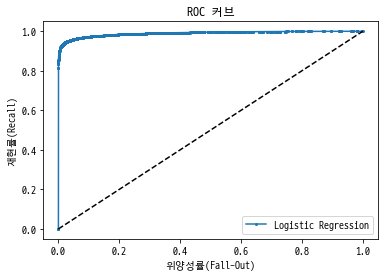

In [116]:
fpr1, tpr1, thresholds1 = roc_curve(
    test.y, testmodel.clf.decision_function(test.X))

plt.plot(fpr1, tpr1, 'o-', ms=2, label="Logistic Regression")
plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.title('ROC 커브')
plt.show()

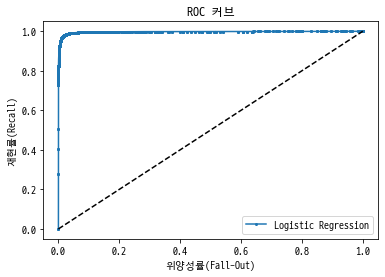

In [16]:
fpr1, tpr1, thresholds1 = roc_curve(
    data2017.y, testmodel.clf.decision_function(data2017.X))

plt.plot(fpr1, tpr1, 'o-', ms=2, label="Logistic Regression")
plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.title('ROC 커브')
plt.show()

In [ ]:
cvmodel = DiabetesModelingLR()
cvmodel.make_model(X=data2017.X, y=data2017.y, CV=True)
# data size 0.9M, time 29m

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52964 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s

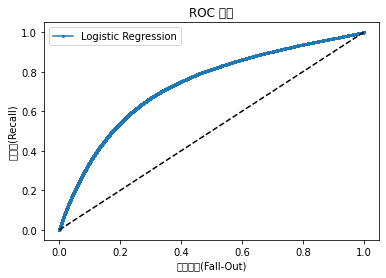

In [35]:
fpr1, tpr1, thresholds1 = roc_curve(
    data2017.y, testmodel.clf.decision_function(data2017.X))

plt.plot(fpr1, tpr1, 'o-', ms=2, label="Logistic Regression")
plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.title('ROC 커브')
plt.show()

In [ ]:
# training data = year 2017, test data = year 2018
model = DiabetesModelingLR()
model.make_model(X_train=data2017.X, y_train=data2017.y,
                 X_test=data2018.X, y_test=data2018.y)

In [ ]:
model.show_result()

# Grid Search by Features
### (not hyper-parameters)

# Generate Feature Combinations

In [57]:
grid_features = test.data_infos
combs, feature_combinations = [], []
for i in range(1, len(grid_features)):
    t = []
    t.append(list(itertools.combinations(grid_features, i)))
    for j in range(len(t)):
        combs.append(t[j])
for f in combs:
    for ff in f:
        feature_combinations.append(list(ff))
feature_combinations.append(test.data_infos)
if 0:
    for f in feature_combinations:
        print(f)

# Store results from all combinations

In [15]:
# No FBS Margin
results = []
for features in feature_combinations:
    gridmodel = DiabetesModelingLR()
    gridmodel.make_model(X=test.get_specific_data(features), y=test.y, CV=5)
    results.append(gridmodel.get_result())
clear_output()
# 7h with full size, CV=2
# 17m with 10만+10만, fbs pivot=120 CV=False
# 5m with 

In [58]:
# No Priority
results = []
for features in feature_combinations:
    gridmodel = DiabetesModelingLR()
    gridmodel.make_model(X=test.get_specific_data(features), y=test.y, CV=5)
    results.append(gridmodel.get_result())
clear_output()

# Show f1_scores from grid search

In [38]:
# No FBS Margin
sorted_results = sorted(enumerate([result[0] for result in results[:]]), 
                        reverse=True, key=lambda x: x[1])[:20]
for i, f1 in sorted_results:
    print(f'{f1}:{feature_combinations[i]}')
max_i, max_f1 = sorted_results[0]

0.99411:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
0.99411:['트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
0.99411:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
0.9928:['총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
0.99257:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
0.99257:['총콜레스테롤', '트리글리세라이드', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
0.99257:['트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
0.99257:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
0.99192:['총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
0.99126:['총콜레스테롤', '트리글리세라이드', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
0.98905:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', '혈색소', '(혈청지오티)ALT', '감마지티피', 'BMI']
0.98905:['트리

In [59]:
# No Priority
sorted_results = sorted(enumerate([result[0] for result in results[:]]), 
                        reverse=True, key=lambda x: x[1])[:20]
for i, f1 in sorted_results:
    print(f'{f1}:{feature_combinations[i]}')
max_i, max_f1 = sorted_results[0]

0.63036:['총콜레스테롤', '트리글리세라이드', '(혈청지오티)ALT', 'BMI']
0.6302:['총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '(혈청지오티)ALT', 'BMI']
0.62976:['총콜레스테롤', '트리글리세라이드', '혈색소', '(혈청지오티)ALT', 'BMI']
0.62923:['총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '혈색소', '(혈청지오티)ALT', 'BMI']
0.62921:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '(혈청지오티)AST', '(혈청지오티)ALT', 'BMI']
0.62911:['총콜레스테롤', 'HDL콜레스테롤', 'LDL콜레스테롤', '(혈청지오티)ALT', 'BMI']
0.62893:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)ALT', 'BMI']
0.62891:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '(혈청지오티)ALT', 'BMI']
0.6288:['트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '(혈청지오티)ALT', 'BMI']
0.62861:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', '(혈청지오티)AST', '(혈청지오티)ALT', 'BMI']
0.62833:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', 'BMI']
0.62817:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', '(혈청지오티)ALT', 'BMI']
0.62795:['트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '(혈청지오티)ALT', 'BMI']
0.62773:['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', '혈색소', '(혈청지오티)ALT', '

In [42]:
# No FBS Margin
print(f'Highest f1 score is {max_f1}, features : {feature_combinations[max_i]}')

Highest f1 score is 0.99411, features : ['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']


In [60]:
# No Priority
print(f'Highest f1 score is {max_f1}, features : {feature_combinations[max_i]}')

Highest f1 score is 0.63036, features : ['총콜레스테롤', '트리글리세라이드', '(혈청지오티)ALT', 'BMI']


# Show Outliers

In [ ]:
test.show_outliers(feature='체중(5Kg단위)', pivot=100, not_diabetes_only=False)

In [ ]:
# show_outliers(self, feature, pivot, not_diabetes_only=True)
look.show_outliers(feature='총콜레스테롤', pivot=500, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='식전혈당(공복혈당)', pivot=600, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='트리글리세라이드', pivot=700, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='LDL콜레스테롤', pivot=300, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='허리둘레', pivot=150, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='감마지티피', pivot=300, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='혈색소', pivot=18, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='(혈청지오티)ALT', pivot=200, not_diabetes_only=True)

In [ ]:
look.show_outliers(feature='(혈청지오티)AST', pivot=200, not_diabetes_only=False)

# Grid Search

In [189]:
class GridSearch():
    def __init__(self, grid_parameters, X, y, model=LogisticRegression):
        self.model = model
        self.grid_parameters = grid_parameters
        self.X = X
        self.y = y
        self.clf = None
        self.best_parameters = None
        self.best_estimator = None

    def make_estimator(self, model, X=None, y=None, default_parameters=None,
                       grid_parameters=None, cross_validation: int = 2):
        #         clf = model(**default_parameters)
        clf = model(max_iter=5000)
        estimator = GridSearchCV(clf, grid_parameters,
                                 cv=cross_validation, n_jobs=-1)
#         dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio',
#                    'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver',
#                    'tol', 'verbose', 'warm_start'])
        estimator.fit(X, y)

        return estimator

    def grid_search(self):
        X_train, X_test, y_train, y_test = split_set(self.X, self.y)
        self.clf = self.make_estimator(X=X_train, y=y_train, model=self.model,
                                       grid_parameters=self.grid_parameters)
#         self.clf = self.make_estimator(X=X_train, y=y_train, model=self.model,
#                                        default_parameters=dict(solver='lbfgs'),
#                                        grid_parameters=self.grid_parameters)
        self.best_parameters = self.clf.best_params_
        self.best_estimator = self.clf.best_estimator_

        # get best accuracy on training set
        print('Input Grid Parameters')
        print(self.grid_parameters)

        print('Accuracy on training set')
        print(round(self.clf.best_score_, 5))

        print('Accuracy on test set')
        print(round(self.best_estimator.score(X_test, y_test), 5))

        print(f'Best Parameters : {self.best_parameters}')

In [190]:
# dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio',
#            'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver',
#            'tol', 'verbose', 'warm_start'])
grid_parameters = {
    'C': [1e-4, 1e-3, 1e-2, 1, 10, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']
    #     'C': [1e-4, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1000], # 1000 means no regularization
    #     'solver': ['saga']
}
features = ['허리둘레', '총콜레스테롤', '트리글리세라이드',
            'LDL콜레스테롤', '혈색소', '(혈청지오티)ALT', '감마지티피', 'BMI']
grid_search_2017_LR = GridSearch(grid_parameters=grid_parameters, model=LogisticRegression,
                                 X=gridtest.get_specific_data(features), y=gridtest.y)
grid_search_2017_LR.grid_search()

Input Grid Parameters
{'C': [0.0001, 0.001, 0.01, 1, 10, 1000], 'penalty': ['l1', 'l2'], 'solver': ['saga']}
Accuracy on training set
0.66499
Accuracy on test set
0.66454
Best Parameters : {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}


In [197]:
LogisticRegressionCV.get_params(LogisticRegressionCV()).keys()

dict_keys(['Cs', 'class_weight', 'cv', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratios', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'refit', 'scoring', 'solver', 'tol', 'verbose'])

In [180]:
GridSearchCV.get_params(LogisticRegression()).keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [ ]:
def scale(train_data, scatter_show_YN=False, kdeplot_show_YN=False):
    from sklearn.preprocessing import MinMaxScaler
    minMaxScaler = MinMaxScaler()
    %time print(minMaxScaler.fit(train_data))
    train_data_minMaxScaled = pd.DataFrame(
        minMaxScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    %time print(maxAbsScaler.fit(train_data))
    train_data_maxAbsScaled = pd.DataFrame(
        maxAbsScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import StandardScaler
    standardScaler = StandardScaler()
    %time print(standardScaler.fit(train_data))
    train_data_standardScaled = pd.DataFrame(
        standardScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import RobustScaler
    robustScaler = RobustScaler()
    %time print(robustScaler.fit(train_data))
    train_data_robustScaled = pd.DataFrame(
        robustScaler.transform(train_data), columns=['x1', 'x2'])

    if(kdeplot_show_YN is True):
        kdeplot_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled,
                     train_data_standardScaled, train_data_robustScaled)

    if(scatter_show_YN is True):
        scatter_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled,
                     train_data_standardScaled, train_data_robustScaled)

In [ ]:
def scatter_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(19, 4))
    scatter_sub_draw(sub_ax=ax[0], x=train_data['x1'], y=train_data['x2'],
                     title='train_data', size=2, color1='k', color2='c')
    scatter_sub_draw(sub_ax=ax[1], x=train_data_minMaxScaled['x1'], y=train_data_minMaxScaled['x2'],
                     title='train_data_minMaxScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[2], x=train_data_maxAbsScaled['x1'], y=train_data_maxAbsScaled['x2'],
                     title='train_data_maxAbsScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[3], x=train_data_standardScaled['x1'], y=train_data_standardScaled['x2'],
                     title='train_data_standardScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[4], x=train_data_robustScaled['x1'], y=train_data_robustScaled['x2'],
                     title='train_data_robustScaled', size=2, color1='g', color2='c')


def scatter_sub_draw(sub_ax, x, y, title, size, color1, color2):
    sub_ax.scatter(x, y, s=size, color=color1)
    sub_ax.grid(True)
    sub_ax.set_title(title)
    sub_ax.set_xlabel(x.name)
    sub_ax.set_ylabel(y.name)
    # median  line draw
    sub_ax.axvline(x=x.median(), color=color2, linestyle='--', linewidth=0.5)
    sub_ax.axhline(y=y.median(), color=color2, linestyle='--', linewidth=0.5)

In [ ]:
def kdeplot_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(19, 4))
    kdeplot_sub_draw(sub_ax=ax[0], x=train_data['x1'], y=train_data['x2'],
                     title='train_data', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[1], x=train_data_minMaxScaled['x1'], y=train_data_minMaxScaled['x2'],
                     title='train_data_minMaxScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[2], x=train_data_maxAbsScaled['x1'], y=train_data_maxAbsScaled['x2'],
                     title='train_data_maxAbsScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[3], x=train_data_standardScaled['x1'], y=train_data_standardScaled['x2'],
                     title='train_data_standardScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[4], x=train_data_robustScaled['x1'], y=train_data_robustScaled['x2'],
                     title='train_data_robustScaled', size=1, color1='r', color2='b')


def kdeplot_sub_draw(sub_ax, x, y, title, size, color1, color2):
    # sns.kdeplot: Fit and plot a univariate or bivariate kernel density estimate
    import seaborn as sns
    sub_ax.grid(True)
    sub_ax.set_title(title)
    sns.kdeplot(x, ax=sub_ax, shade=True, color=color1)
    sns.kdeplot(y, ax=sub_ax, shade=True, color=color2)
    # median  line draw
    sub_ax.axvline(x=x.median(), color=color1, linestyle='--', linewidth=0.5)
    sub_ax.axvline(x=y.median(), color=color2, linestyle='--', linewidth=0.5)

In [ ]:
train_data = pd.DataFrame({
    'x1': X[1],
    'x2': X[2]
})

In [ ]:
scale(train_data, scatter_show_YN=True, kdeplot_show_YN=True)